In [1]:
import os

QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99] 

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import pywt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import random
import numpy as np
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, NBEATSModel, NHiTSModel, XGBModel, RNNModel, BlockRNNModel
from darts.models import AutoARIMA, LinearRegressionModel, RegressionEnsembleModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.metrics import mape, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.tuner import lr_finder
import pytorch_lightning as pl
pl.seed_everything(42)
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
xls = pd.ExcelFile('df_radon_combined.xlsx')

df_radon = {}
for num in xls.sheet_names[2:]:
    df_radon[num] = pd.read_excel(xls, num) 

#remove these indexes
devices = ['1', '2', '5', '9', '17', '23', '27', '28', '36', '44', '48']
for key in list(df_radon):
    if key in devices:
        del df_radon[key]

for key in df_radon:
    print(key)
    df_radon[key]['SyncDate'] = pd.to_datetime(df_radon[key]['SyncDate'])
    print(f"{df_radon[key]['SyncDate'].min()} - {df_radon[key]['SyncDate'].max()}")
    df_radon[key].sort_values(by='SyncDate', ascending=True, inplace=True)
    df_radon[key]['SyncDate'] = df_radon[key]['SyncDate'].dt.floor('H')
    df_radon[key] = df_radon[key].resample('H', on = 'SyncDate').mean()
    df_radon[key] = df_radon[key].interpolate(method='linear', limit_direction='both')
    start_time = pd.to_datetime('2022-05-11T18:29:00.000000000')
    end_time = pd.to_datetime('2023-06-06T12:00:00.000000000')
    df_radon[key] = df_radon[key][(df_radon[key].index >= start_time) & (df_radon[key].index <= end_time)]
    print(f"{df_radon[key].index.min()} - {df_radon[key].index.max()}")

3
2022-05-08 00:16:30 - 2023-06-06 12:25:38
2022-05-11 19:00:00 - 2023-06-06 12:00:00
4
2022-05-08 00:17:23 - 2023-06-06 12:26:06
2022-05-11 19:00:00 - 2023-06-06 12:00:00
7
2022-04-01 10:18:57 - 2023-06-06 12:30:25
2022-05-11 19:00:00 - 2023-06-06 12:00:00
8
2022-04-04 18:52:46 - 2023-06-06 12:27:12
2022-05-11 19:00:00 - 2023-06-06 12:00:00
10
2022-05-08 00:56:00 - 2023-06-06 23:02:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
11
2022-05-08 00:50:01 - 2023-06-07 12:13:32
2022-05-11 19:00:00 - 2023-06-06 12:00:00
13
2022-05-08 00:33:33 - 2023-06-06 23:09:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
15
2022-05-08 00:39:00 - 2023-06-06 23:59:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
16
2022-05-08 00:47:00 - 2023-06-06 23:00:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
18
2022-05-08 00:49:00 - 2023-06-06 23:07:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
19
2022-05-08 00:51:00 - 2023-06-06 23:36:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
20
2022-05-08 00:54:00 - 2023-06-07 12:40:49
20

# Radon 45

In [4]:
df = df_radon['45'].copy()

In [5]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [6]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [7]:
signal = df['Radon'].copy()
wavelet_name='coif9'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [8]:
weather_station = pd.read_csv('weather_data_combined.csv')

In [9]:
weather_station.drop('Date', axis=1, inplace=True)
weather_station['Simple Date'] = pd.to_datetime(weather_station['Simple Date'])
weather_station.sort_values(by='Simple Date', ascending=True, inplace=True)
weather_station['Simple Date'] = weather_station['Simple Date'].dt.floor('H')
weather_station = weather_station.resample('H', on = 'Simple Date').mean()
weather_station = weather_station.interpolate(method='linear', limit_direction='both')

In [10]:
weather_station

Outdoor h Temperature (°F)  Wind Speed (mph)  \
Simple Date                                                         
2022-05-10 00:00:00                       55.74              0.00   
2022-05-10 01:00:00                       54.79              0.00   
2022-05-10 02:00:00                       53.88              0.00   
2022-05-10 03:00:00                       52.49              0.00   
2022-05-10 04:00:00                       51.70              0.00   
...                                         ...               ...   
2023-06-07 19:00:00                       80.57              0.02   
2023-06-07 20:00:00                       77.16              0.00   
2023-06-07 21:00:00                       74.54              0.00   
2023-06-07 22:00:00                       73.51              0.06   
2023-06-07 23:00:00                       72.15              0.00   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
Simple Date                                                  
2022-05-10 00:00:00             0.00                  0.00   
2022-05-10 01:00:00             0.00                  0.00   
2022-05-10 02:00:00             0.00                  0.00   
2022-05-10 03:00:00             0.00                  0.00   
2022-05-10 04:00:00             0.00                  0.00   
...                              ...                   ...   
2023-06-07 19:00:00             0.18                  9.20   
2023-06-07 20:00:00             0.00                  9.20   
2023-06-07 21:00:00             0.00                  9.20   
2023-06-07 22:00:00             0.09                  9.20   
2023-06-07 23:00:00             0.00                  9.20   

                     Wind Direction (°)  Hourly Rain (in/hr)  Event Rain (in)  \
Simple Date                                                                     
2022-05-10 00:00:00              305.17                 0.00             0.00   
2022-05-10 01:00:00              302.58                 0.00             0.00   
2022-05-10 02:00:00              298.92                 0.00             0.00   
2022-05-10 03:00:00              302.92                 0.00             0.00   
2022-05-10 04:00:00              305.17                 0.00             0.00   
...                                 ...                  ...              ...   
2023-06-07 19:00:00              287.08                 0.00             0.00   
2023-06-07 20:00:00              309.83                 0.00             0.00   
2023-06-07 21:00:00              304.83                 0.00             0.00   
2023-06-07 22:00:00              307.83                 0.00             0.00   
2023-06-07 23:00:00              306.58                 0.00             0.00   

                     Daily Rain (in)  Weekly Rain (in)  Monthly Rain (in)  \
Simple Date                                                                 
2022-05-10 00:00:00             0.00              0.00               0.76   
2022-05-10 01:00:00             0.00              0.00               0.76   
2022-05-10 02:00:00             0.00              0.00               0.76   
2022-05-10 03:00:00             0.00              0.00               0.76   
2022-05-10 04:00:00             0.00              0.00               0.76   
...                              ...               ...                ...   
2023-06-07 19:00:00             0.00              0.02               0.02   
2023-06-07 20:00:00             0.00              0.02               0.02   
2023-06-07 21:00:00             0.00              0.02               0.02   
2023-06-07 22:00:00             0.00              0.02               0.02   
2023-06-07 23:00:00             0.00              0.02               0.02   

                     Yearly Rain (in)  Relative Pressure (inHg)  Humidity (%)  \
Simple Date                                                                     
2022-05-10 00:00:00             22.72                     29.13         90.67   
2022-05-10 01:00:

In [11]:
for column in weather_station.columns:
    df[column] = weather_station[column]

In [12]:
df

AirPressure  Humidity  Radon  Temperature  \
SyncDate                                                         
2022-05-11 19:00:00        30.05     37.00   7.36        88.00   
2022-05-11 20:00:00        30.05     41.00   6.93        83.00   
2022-05-11 21:00:00        30.06     45.00   6.52        80.00   
2022-05-11 22:00:00        30.07     49.00   6.12        77.00   
2022-05-11 23:00:00        30.10     50.00   5.73        76.00   
...                          ...       ...    ...          ...   
2023-06-06 08:00:00        29.89     57.50   9.67        77.00   
2023-06-06 09:00:00        29.89     57.00   9.14        79.00   
2023-06-06 10:00:00        29.90     49.00   8.69        86.00   
2023-06-06 11:00:00        29.79     47.00   8.26        78.00   
2023-06-06 12:00:00        30.02     68.00   7.81        74.00   

                     Outdoor h Temperature (°F)  Wind Speed (mph)  \
SyncDate                                                            
2022-05-11 19:00:00                       77.07              0.00   
2022-05-11 20:00:00                       74.87              0.00   
2022-05-11 21:00:00                       72.88              0.00   
2022-05-11 22:00:00                       71.14              0.00   
2022-05-11 23:00:00                       69.29              0.00   
...                                         ...               ...   
2023-06-06 08:00:00                       69.51              0.29   
2023-06-06 09:00:00                       76.43              0.43   
2023-06-06 10:00:00                       81.18              0.68   
2023-06-06 11:00:00                       83.35              0.57   
2023-06-06 12:00:00                       85.52              0.76   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
SyncDate                                                     
2022-05-11 19:00:00             0.09                  5.80   
2022-05-11 20:00:00             0.00                  5.80   
2022-05-11 21:00:00             0.00                  5.80   
2022-05-11 22:00:00             0.00                  5.80   
2022-05-11 23:00:00             0.00                  5.80   
...                              ...                   ...   
2023-06-06 08:00:00             1.03                  2.25   
2023-06-06 09:00:00             1.67                  4.80   
2023-06-06 10:00:00             2.05                  6.17   
2023-06-06 11:00:00             2.52                  6.90   
2023-06-06 12:00:00             2.33                  6.90   

                     Wind Direction (°)  Hourly Rain (in/hr)  ...  \
SyncDate                                                      ...   
2022-05-11 19:00:00              313.08                 0.00  ...   
2022-05-11 20:00:00              302.08                 0.00  ...   
2022-05-11 21:00:00              301.67                 0.00  ...   
2022-05-11 22:00:00              306.00                 0.00  ...   
2022-05-11 23:00:00              301.50                 0.00  ...   
...                                 ...                  ...  ...   
2023-06-06 08:00:00              307.83                 0.00  ...   
2023-06-06 09:00:00              317.17                 0.00  ...   
2023-06-06 10:00:00              308.50                 0.00  ...   
2023-06-06 11:00:00              287.25                 0.00  ...   
2023-06-06 12:00:00              303.50                 0.00  ...   

                     Weekly Rain (in)  Monthly Rain (in)  Yearly Rain (in)  \
SyncDate                                                                     
2022-05-11 19:00:00              0.00               0.76             22.72   
2022-05-11 20:00:00              0.00               0.76             22.72   
2022-05-11 21:00:00              0.00               0.76             22.72   
2022-05-11 22:00:00              0.00               0.76             22.72   
2022-05-11 23:00:00              0.00               0.76             22.72   
...          

In [13]:
df.dropna(inplace=True)

In [14]:
df

AirPressure  Humidity  Radon  Temperature  \
SyncDate                                                         
2022-05-11 19:00:00        30.05     37.00   7.36        88.00   
2022-05-11 20:00:00        30.05     41.00   6.93        83.00   
2022-05-11 21:00:00        30.06     45.00   6.52        80.00   
2022-05-11 22:00:00        30.07     49.00   6.12        77.00   
2022-05-11 23:00:00        30.10     50.00   5.73        76.00   
...                          ...       ...    ...          ...   
2023-06-06 08:00:00        29.89     57.50   9.67        77.00   
2023-06-06 09:00:00        29.89     57.00   9.14        79.00   
2023-06-06 10:00:00        29.90     49.00   8.69        86.00   
2023-06-06 11:00:00        29.79     47.00   8.26        78.00   
2023-06-06 12:00:00        30.02     68.00   7.81        74.00   

                     Outdoor h Temperature (°F)  Wind Speed (mph)  \
SyncDate                                                            
2022-05-11 19:00:00                       77.07              0.00   
2022-05-11 20:00:00                       74.87              0.00   
2022-05-11 21:00:00                       72.88              0.00   
2022-05-11 22:00:00                       71.14              0.00   
2022-05-11 23:00:00                       69.29              0.00   
...                                         ...               ...   
2023-06-06 08:00:00                       69.51              0.29   
2023-06-06 09:00:00                       76.43              0.43   
2023-06-06 10:00:00                       81.18              0.68   
2023-06-06 11:00:00                       83.35              0.57   
2023-06-06 12:00:00                       85.52              0.76   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
SyncDate                                                     
2022-05-11 19:00:00             0.09                  5.80   
2022-05-11 20:00:00             0.00                  5.80   
2022-05-11 21:00:00             0.00                  5.80   
2022-05-11 22:00:00             0.00                  5.80   
2022-05-11 23:00:00             0.00                  5.80   
...                              ...                   ...   
2023-06-06 08:00:00             1.03                  2.25   
2023-06-06 09:00:00             1.67                  4.80   
2023-06-06 10:00:00             2.05                  6.17   
2023-06-06 11:00:00             2.52                  6.90   
2023-06-06 12:00:00             2.33                  6.90   

                     Wind Direction (°)  Hourly Rain (in/hr)  ...  \
SyncDate                                                      ...   
2022-05-11 19:00:00              313.08                 0.00  ...   
2022-05-11 20:00:00              302.08                 0.00  ...   
2022-05-11 21:00:00              301.67                 0.00  ...   
2022-05-11 22:00:00              306.00                 0.00  ...   
2022-05-11 23:00:00              301.50                 0.00  ...   
...                                 ...                  ...  ...   
2023-06-06 08:00:00              307.83                 0.00  ...   
2023-06-06 09:00:00              317.17                 0.00  ...   
2023-06-06 10:00:00              308.50                 0.00  ...   
2023-06-06 11:00:00              287.25                 0.00  ...   
2023-06-06 12:00:00              303.50                 0.00  ...   

                     Weekly Rain (in)  Monthly Rain (in)  Yearly Rain (in)  \
SyncDate                                                                     
2022-05-11 19:00:00              0.00               0.76             22.72   
2022-05-11 20:00:00              0.00               0.76             22.72   
2022-05-11 21:00:00              0.00               0.76             22.72   
2022-05-11 22:00:00              0.00               0.76             22.72   
2022-05-11 23:00:00              0.00               0.76             22.72   
...          

In [15]:
# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")
gaps(df)

no missing values



In [16]:
df.describe()

AirPressure  Humidity    Radon  Temperature  \
count     9,378.00  9,378.00 9,378.00     9,378.00   
mean         30.10     62.16    18.13        72.54   
std           0.14     13.24    20.50        17.99   
min          29.58     13.00    -0.61        15.00   
25%          30.01     54.04     0.87        60.00   
50%          30.10     63.00    12.20        74.00   
75%          30.19     72.00    29.45        82.55   
max          30.56     93.00   177.31       142.00   

       Outdoor h Temperature (°F)  Wind Speed (mph)  Wind Gust (mph)  \
count                    9,378.00          9,378.00         9,378.00   
mean                        62.98              0.23             0.90   
std                         14.85              0.37             1.15   
min                          7.12              0.00             0.00   
25%                         52.55              0.00             0.00   
50%                         64.87              0.03             0.37   
75%                         73.89              0.34             1.56   
max                         98.02              5.35             8.02   

       Max Daily Gust (mph)  Wind Direction (°)  Hourly Rain (in/hr)  ...  \
count              9,378.00            9,378.00             9,378.00  ...   
mean                   4.70              297.71                 0.01  ...   
std                    3.49               28.84                 0.04  ...   
min                    0.00                1.33                 0.00  ...   
25%                    1.48              289.00                 0.00  ...   
50%                    4.50              305.58                 0.00  ...   
75%                    6.90              316.08                 0.00  ...   
max                   20.60              347.67                 1.23  ...   

       Weekly Rain (in)  Monthly Rain (in)  Yearly Rain (in)  \
count          9,378.00           9,378.00          9,378.00   
mean               0.54               2.88             52.63   
std                0.85               2.98             18.94   
min                0.00               0.00             22.72   
25%                0.00               0.76             37.85   
50%                0.09               2.14             47.13   
75%                0.72               3.72             69.48   
max                3.90              14.68             83.42   

       Relative Pressure (inHg)  Humidity (%)  Ultra-Violet Radiation Index  \
count                  9,378.00      9,378.00                      9,378.00   
mean                      29.02         76.37                          0.96   
std                        0.14         17.72                          1.79   
min                       28.40         17.17                          0.00   
25%                       28.93         65.00                          0.00   
50%                       29.02         79.92                          0.00   
75%                       29.11         91.58                          1.00   
max                       29.51         99.00                          8.00   

       Solar Radiation (W/m^2)  Absolute Pressure (inHg)  \
count                 9,378.00                  9,378.00   
mean                    119.51                     29.02   
std                     200.38                      0.14   
min                       0.00                     28.40   
25%                       0.00                     28.93   
50%                       2.59                     29.02   
75%                     144.45                     29.11   
max                     872.65                     29.51   

       Avg Wind Direction (10 mins) (°)  Avg Wind Speed (10 mins) (mph)  
count                          9,378.00                        9,378.00  
mean                             308.30                            0.15  
std                               18.81                            0.31  
min                                1.42            

In [17]:
for column in df.columns:
    df[column] = df[column].astype('float32')
    if column == 'Radon':
        continue
    else:
        for i in range(1,40):
            df[column+'_lag_'+str(i)] = df[column].shift(i)

In [18]:
df.fillna(0, inplace=True)

In [19]:
# check correlations of features with price
df_corr = df.corr(method="spearman")
print(df_corr.shape)
print("correlation with Radon:")
df_corrP = pd.DataFrame(df_corr["Radon"].sort_values(ascending=False))
df_corrP

(841, 841)
correlation with Radon:


Radon
Radon                               1.00
Outdoor h Temperature (°F)_lag_26   0.60
Outdoor h Temperature (°F)_lag_25   0.60
Outdoor h Temperature (°F)_lag_27   0.60
Outdoor h Temperature (°F)_lag_24   0.60
...                                  ...
Yearly Rain (in)_lag_35            -0.61
Yearly Rain (in)_lag_36            -0.61
Yearly Rain (in)_lag_37            -0.61
Yearly Rain (in)_lag_38            -0.61
Yearly Rain (in)_lag_39            -0.61

[841 rows x 1 columns]

In [20]:
# highest absolute correlations with Radon
pd.options.display.float_format = '{:,.2f}'.format
df_corrH = df_corrP[(df_corrP["Radon"]) >= 0.6009]
df_corrH

Radon
Radon                               1.00
Outdoor h Temperature (°F)_lag_26   0.60
Outdoor h Temperature (°F)_lag_25   0.60

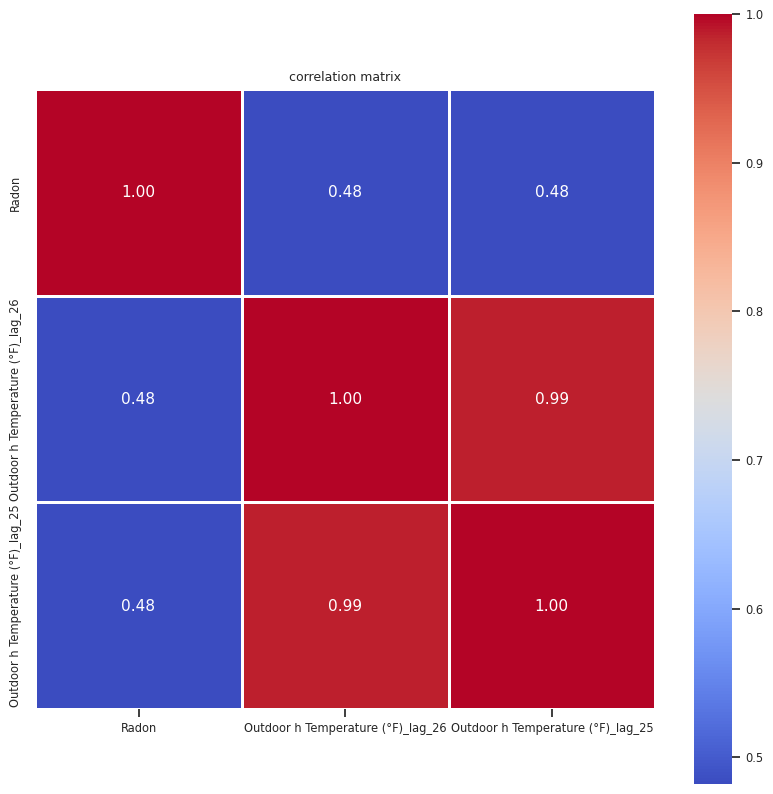

In [21]:
# helper method: correlation matrix as heatmap
def corr_heatmap(df):
    idx = df.corr().sort_values("Radon", ascending=False).index
    df_sorted = df.loc[:, idx]  # sort dataframe columns by their correlation 

    #plt.figure(figsize = (15,15))
    sns.set(font_scale=0.75)
    ax = sns.heatmap(df_sorted.corr().round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap="coolwarm", 
            fmt = ".2f", 
            annot_kws = {"size": 11})
    ax.xaxis.tick_bottom()
    plt.title("correlation matrix")
    plt.show()



# visualize correlations with price     

df4 = df[df_corrH.index]   # keep the components with at least modest correlations

plt.figure(figsize = (10,10))
corr_heatmap(df4)

In [22]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9378 entries, 2022-05-11 19:00:00 to 2023-06-06 12:00:00
Freq: H
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Radon                              9378 non-null   float32
 1   Outdoor h Temperature (°F)_lag_26  9378 non-null   float32
 2   Outdoor h Temperature (°F)_lag_25  9378 non-null   float32
dtypes: float32(3)
memory usage: 183.2 KB


In [23]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df4["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [24]:
# create time series object for the feature columns
df_covF = df4.loc[:, df4.columns != "Radon"]
df_covF = df_covF.loc[:, df_covF.columns != 'Outdoor h Temperature (°F)_lag_25']
ts_covF = TimeSeries.from_dataframe(df_covF, fill_missing_dates=True, freq="H")

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['Outdoor h Temperature (°F)_lag_26'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [25]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(9378, 1, 1)

In [26]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [27]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-06-06 12:00:00   0.05

In [28]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(split_point=9210)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  
# covF_t = ts_covF
# covF_ttrain = covF_train
# covF_ttest = covF_test
# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component            Outdoor h Temperature (°F)_lag_26
SyncDate                                              
2022-05-11 19:00:00                               0.00
2023-06-06 12:00:00                               0.70

In [29]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-05-30 13:00:00   0.07

In [36]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_rnn_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None


    model = RNNModel(
        model=model_args['model'],
        input_chunk_length=model_args['in_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name=f"{model_args['model']} RNN model",
        n_rnn_layers=model_args['n_rnn_layers'],
        training_length=model_args['in_len']+20,
        hidden_dim=model_args['hidden_dim'],
        dropout=model_args['dropout'],
        loss_fn=SmapeLoss(),
#         likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42,
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                future_covariates=covF_t,
                val_series=val_series,
                val_future_covariates=covF_t,)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                future_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [37]:
def build_fit_rnn_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices":1,
            'callbacks': callbacks,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None


    model = RNNModel(
        model=model_args['model'],
        input_chunk_length=model_args['in_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name=f"{model_args['model']} RNN model return",
        n_rnn_layers=model_args['n_rnn_layers'],
        training_length=model_args['in_len']+20,
        hidden_dim=model_args['hidden_dim'],
        dropout=model_args['dropout'],
        loss_fn=SmapeLoss(),
#         likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                future_covariates=covF_t,
                val_series=val_series,
                val_future_covariates=covF_t,)
#     if save_model:
#         print("have saved the model after training:", mpath)
#         model.save_model(mpath)
    return model

In [38]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "batch_size": tune.choice([32,64,128]),
    "in_len": tune.randint(1,40),
    "dropout":tune.uniform(0.1,0.5),
    "model":tune.choice(['RNN','LSTM','GRU']),
    "hidden_dim":tune.randint(1,32),
    "n_rnn_layers":tune.randint(1,3),
    "lr":tune.loguniform(1e-5,1e-1),
    "include_hour":tune.choice([True,False]),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_rnn_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="rnn_tune_cov",

)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-07 21:59:21 (running for 00:00:00.16)
Memory usage on this node: 22.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 1/100 (1 RUNNING)
+------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+
| Trial name                   | status   | loc                 |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |          lr | include_hour   |
|------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------|
| build_fit_rnn_mode

(build_fit_rnn_model pid=951770) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=951770)   rank_zero_deprecation(
(build_fit_rnn_model pid=951770) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=951770)   rank_zero_deprecation(
(build_fit_rnn_model pid=951770) Auto select gpus: [0]
(build_fit_rnn_model pid=951770) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=951770) TPU available: False, using: 0 TP

(build_fit_rnn_model pid=952007) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.36421577009087025 and num_layers=1
(build_fit_rnn_model pid=952007)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=952007) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=952007)   rank_zero_deprecation(
(build_fit_rnn_model pid=952007) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 21:59:30 (running for 00:00:09.61)
Memory usage on this node: 11.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+
| Trial name                   | status   | loc                 |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |          lr | include_hour   |
|------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+-----------

(build_fit_rnn_model pid=951995) Auto select gpus: [0]
(build_fit_rnn_model pid=951995) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=951995) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=951995) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=951995) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=951995) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=951997) Auto select gpus: [0]
(build_fit_rnn_model pid=951997) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=951997) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=951997) IPU available: False, using: 0 IPUs
(build

(build_fit_rnn_model pid=951995) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=951995)   rank_zero_warn(
(build_fit_rnn_model pid=951995) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=951995)   rank_zero_warn(
(build_fit_rnn_model pid=952001) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=

(build_fit_rnn_model pid=951993) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=951993)   rank_zero_warn(
(build_fit_rnn_model pid=951993) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=951993)   rank_zero_warn(
(build_fit_rnn_model pid=952009) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logge

== Status ==
Current time: 2023-07-07 21:59:35 (running for 00:00:14.62)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+
| Trial name                   | status   | loc                 |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |          lr | include_hour   |
|------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+-----------

(build_fit_rnn_model pid=951770) Auto select gpus: [0]
(build_fit_rnn_model pid=951770) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=951770) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=951770) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=951770) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=951770) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=951770) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.44it/s]


(build_fit_rnn_model pid=953623) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=953623)   rank_zero_deprecation(
(build_fit_rnn_model pid=953623) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=953623)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 21:59:48 (running for 00:00:27.48)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b87e26b2 with q_smape=134.42128896713257 and parameters={'batch_size': 128, 'in_len': 39, 'dropout': 0.4891412516453124, 'model': 'RNN', 'hidden_dim': 8, 'n_rnn_layers': 2, 'lr': 0.00022150265098655461, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 10/100 (1 PENDING, 8 RUNNING, 1 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=953623) Auto select gpus: [0]
(build_fit_rnn_model pid=953623) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=953623) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=953623) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=953623) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=953623) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=953623) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=953623) 
(build_fit_rnn_model pid=953623)   | Name          | Type             | Params
(build_fit_rnn_model pid=953623) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.73it/s]


(build_fit_rnn_model pid=951997) Auto select gpus: [0]
(build_fit_rnn_model pid=951997) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=951997) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=951997) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=951997) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=951997) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=951997) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=953904) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus

== Status ==
Current time: 2023-07-07 21:59:56 (running for 00:00:35.47)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b87e26b2 with q_smape=134.42128896713257 and parameters={'batch_size': 128, 'in_len': 39, 'dropout': 0.4891412516453124, 'model': 'RNN', 'hidden_dim': 8, 'n_rnn_layers': 2, 'lr': 0.00022150265098655461, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=953904) Auto select gpus: [0]
(build_fit_rnn_model pid=953904) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=953904) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=953904) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=953904) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=953904) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=953904) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=953904) 
(build_fit_rnn_model pid=953904)   | Name          | Type             | Params
(build_fit_rnn_model pid=953904) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:00:01 (running for 00:00:40.48)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b87e26b2 with q_smape=134.42128896713257 and parameters={'batch_size': 128, 'in_len': 39, 'dropout': 0.4891412516453124, 'model': 'RNN', 'hidden_dim': 8, 'n_rnn_layers': 2, 'lr': 0.00022150265098655461, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=952009) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=952009)   rank_zero_deprecation(
(build_fit_rnn_model pid=952009) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=952009)   rank_zero_deprecation(
(build_fit_rnn_model pid=952009) Auto select gpus: [0]
(build_fit_rnn_model pid=952009) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=952009) TPU available: False, using: 0 TP

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=952001) Auto select gpus: [0]
(build_fit_rnn_model pid=952001) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=952001) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=952001) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=952001) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=952001) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=952001) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.14it/s]
== Status ==
Current time: 2023-07-07 22:00:09 (running for 00:00:47.89)
Memory usage on this node: 23.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f2f1285c with q_smape=98.638516664505 and parameters={'batch_size': 32, 'in_len': 36, 'dropout': 0.49902933193528165, 'model': 'GRU', 'hidden_dim': 16, 'n_rnn_layers': 1, 'lr': 0.0027485948010565428, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Tri

(build_fit_rnn_model pid=954141) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=954141)   rank_zero_deprecation(
(build_fit_rnn_model pid=954141) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=954141)   rank_zero_deprecation(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.90it/s]


(build_fit_rnn_model pid=953623) Auto select gpus: [0]
(build_fit_rnn_model pid=953623) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=953623) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=953623) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=953623) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=953623) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=953623) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=954141) Auto select gpus: [0]
(build_fit_rnn_model pid=954141) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=954141) TPU available: False, using: 0 TPU cores


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=953904) Auto select gpus: [0]
(build_fit_rnn_model pid=953904) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=953904) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=953904) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=953904) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=953904) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=953904) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.23it/s]


(build_fit_rnn_model pid=954374) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=954374)   rank_zero_deprecation(
(build_fit_rnn_model pid=954374) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=954374)   rank_zero_deprecation(
(build_fit_rnn_model pid=954374) Auto select gpus: [0]
(build_fit_rnn_model pid=954374) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=954374) TPU available: False, using: 0 TP

(build_fit_rnn_model pid=954537) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=954537)   rank_zero_warn(
(build_fit_rnn_model pid=954537) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=954537)   rank_zero_warn(
(build_fit_rnn_model pid=954537) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=AL

== Status ==
Current time: 2023-07-07 22:00:14 (running for 00:00:53.47)
Memory usage on this node: 16.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8ae5e72 with q_smape=78.50213646888733 and parameters={'batch_size': 128, 'in_len': 27, 'dropout': 0.36368363646757407, 'model': 'RNN', 'hidden_dim': 23, 'n_rnn_layers': 2, 'lr': 2.464499014244531e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 15/100 (8 RUNNING, 7 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size | 

(build_fit_rnn_model pid=954701) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=954701) 
(build_fit_rnn_model pid=954701)   | Name          | Type             | Params
(build_fit_rnn_model pid=954701) ---------------------------------------------------
(build_fit_rnn_model pid=954701) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=954701) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=954701) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=954701) 3 | rnn           | RNN              | 437   
(build_fit_rnn_model pid=954701) 4 | V             | Linear           | 20    
(build_fit_rnn_model pid=954701) ---------------------------------------------------
(build_fit_rnn_model pid=954701) 457       Trainable params
(build_fit_rnn_model pid=954701) 0         Non-trainable params
(build_fit_rnn_model pid=954701) 457       Total params
(build_fit_rnn_model pid=954701) 0.002     Total estimated model pa

== Status ==
Current time: 2023-07-07 22:00:21 (running for 00:01:00.78)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8ae5e72 with q_smape=78.50213646888733 and parameters={'batch_size': 128, 'in_len': 27, 'dropout': 0.36368363646757407, 'model': 'RNN', 'hidden_dim': 23, 'n_rnn_layers': 2, 'lr': 2.464499014244531e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=951995) Auto select gpus: [0]
(build_fit_rnn_model pid=951995) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=951995) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=951995) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=951995) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=951995) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=951995) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=951993) Auto select gpus: [0]
(build_fit_rnn_model pid=951993) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=951993) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=951993) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=951993) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=951993) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=951993) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.20it/s]


(build_fit_rnn_model pid=955328) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=955328)   rank_zero_deprecation(
(build_fit_rnn_model pid=955328) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=955328)   rank_zero_deprecation(
(build_fit_rnn_model pid=955328) Auto select gpus: [0]
(build_fit_rnn_model pid=955328) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=955328) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:00:28 (running for 00:01:07.48)
Memory usage on this node: 23.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8ae5e72 with q_smape=78.50213646888733 and parameters={'batch_size': 128, 'in_len': 27, 'dropout': 0.36368363646757407, 'model': 'RNN', 'hidden_dim': 23, 'n_rnn_layers': 2, 'lr': 2.464499014244531e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=955328) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=955328) 
(build_fit_rnn_model pid=955328)   | Name          | Type             | Params
(build_fit_rnn_model pid=955328) ---------------------------------------------------
(build_fit_rnn_model pid=955328) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=955328) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=955328) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=955328) 3 | rnn           | GRU              | 1.5 K 
(build_fit_rnn_model pid=955328) 4 | V             | Linear           | 13    
(build_fit_rnn_model pid=955328) ---------------------------------------------------
(build_fit_rnn_model pid=955328) 1.5 K     Trainable params
(build_fit_rnn_model pid=955328) 0         Non-trainable params
(build_fit_rnn_model pid=955328) 1.5 K     Total params
(build_fit_rnn_model pid=955328) 0.006     Total estimated model pa

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.92it/s]


(build_fit_rnn_model pid=954374) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=954374)   rank_zero_deprecation(
(build_fit_rnn_model pid=954374) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=954374)   rank_zero_deprecation(
(build_fit_rnn_model pid=954374) Auto select gpus: [0]
(build_fit_rnn_model pid=954374) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=954374) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:00:38 (running for 00:01:17.49)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8ae5e72 with q_smape=78.50213646888733 and parameters={'batch_size': 128, 'in_len': 27, 'dropout': 0.36368363646757407, 'model': 'RNN', 'hidden_dim': 23, 'n_rnn_layers': 2, 'lr': 2.464499014244531e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 19/100 (1 PENDING, 8 RUNNING, 10 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=955801) Auto select gpus: [0]
(build_fit_rnn_model pid=955801) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=955801) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=955801) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=955801) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=955801) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=955801) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=955801) 
(build_fit_rnn_model pid=955801)   | Name          | Type             | Params
(build_fit_rnn_model pid=955801) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.70it/s]


(build_fit_rnn_model pid=956045) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=956045)   rank_zero_deprecation(
(build_fit_rnn_model pid=956045) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=956045)   rank_zero_deprecation(
(build_fit_rnn_model pid=956043) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

== Status ==
Current time: 2023-07-07 22:00:46 (running for 00:01:25.53)
Memory usage on this node: 22.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4dadf265 with q_smape=14.848215878009796 and parameters={'batch_size': 32, 'in_len': 12, 'dropout': 0.3029739514486067, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 2, 'lr': 0.029127937215734697, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=956043) Auto select gpus: [0]
(build_fit_rnn_model pid=956043) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=956043) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=956043) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=956043) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=956043) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=956045) Auto select gpus: [0]
(build_fit_rnn_model pid=956045) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=956045) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=956045) IPU available: False, using: 0 IPUs
(build

== Status ==
Current time: 2023-07-07 22:00:51 (running for 00:01:30.54)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4dadf265 with q_smape=14.848215878009796 and parameters={'batch_size': 32, 'in_len': 12, 'dropout': 0.3029739514486067, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 2, 'lr': 0.029127937215734697, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=955801) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=955801)   rank_zero_deprecation(
(build_fit_rnn_model pid=955801) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=955801)   rank_zero_deprecation(
(build_fit_rnn_model pid=955801) Auto select gpus: [0]
(build_fit_rnn_model pid=955801) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=955801) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.18it/s]


(build_fit_rnn_model pid=956511) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=956511)   rank_zero_deprecation(
(build_fit_rnn_model pid=956511) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=956511)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:01:00 (running for 00:01:39.51)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4dadf265 with q_smape=14.848215878009796 and parameters={'batch_size': 32, 'in_len': 12, 'dropout': 0.3029739514486067, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 2, 'lr': 0.029127937215734697, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=956511) Auto select gpus: [0]
(build_fit_rnn_model pid=956511) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=956511) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=956511) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=956511) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=956511) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=956511) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=956511) 
(build_fit_rnn_model pid=956511)   | Name          | Type             | Params
(build_fit_rnn_model pid=956511) ---------------------------------------------------
(bu

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=954862) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=954862)   rank_zero_deprecation(
(build_fit_rnn_model pid=954862) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=954862)   rank_zero_deprecation(
(build_fit_rnn_model pid=954862) Auto select gpus: [0]
(build_fit_rnn_model pid=954862) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=954862) TPU available: False, using: 0 TP

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=955489) Auto select gpus: [0]
(build_fit_rnn_model pid=955489) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=955489) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=955489) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=955489) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=955489) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=955489) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.24it/s]


(build_fit_rnn_model pid=954537) Auto select gpus: [0]
(build_fit_rnn_model pid=954537) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=954537) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=954537) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=954537) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=954537) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=954537) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.45it/s]
== Status ==
Current time: 2023-07-07 22:01:07 (running for 00:01:45.85)
Memory usage on this node: 20.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4dadf265 with q_smape=14.848215878009796 and parameters={'batch_size': 32, 'in_len': 12, 'dropout': 0.3029739514486067, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 2, 'lr': 0.029127937215734697, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
|

(build_fit_rnn_model pid=956758) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=956758)   rank_zero_deprecation(
(build_fit_rnn_model pid=956758) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=956758)   rank_zero_deprecation(
(build_fit_rnn_model pid=956756) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=956045) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=956045)   rank_zero_deprecation(
(build_fit_rnn_model pid=956045) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=956045)   rank_zero_deprecation(
(build_fit_rnn_model pid=956045) Auto select gpus: [0]
(build_fit_rnn_model pid=956045) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=956045) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.76it/s]
== Status ==
Current time: 2023-07-07 22:01:12 (running for 00:01:51.37)
Memory usage on this node: 21.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4dadf265 with q_smape=14.848215878009796 and parameters={'batch_size': 32, 'in_len': 12, 'dropout': 0.3029739514486067, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 2, 'lr': 0.029127937215734697, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
|

(build_fit_rnn_model pid=957223) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=957223)   rank_zero_deprecation(
(build_fit_rnn_model pid=957223) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=957223)   rank_zero_deprecation(
(build_fit_rnn_model pid=957225) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=956511) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=956511)   rank_zero_deprecation(
(build_fit_rnn_model pid=956511) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=956511)   rank_zero_deprecation(
(build_fit_rnn_model pid=956511) Auto select gpus: [0]
(build_fit_rnn_model pid=956511) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=956511) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.54it/s]


(build_fit_rnn_model pid=957223) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=957223) 
(build_fit_rnn_model pid=957223)   | Name          | Type             | Params
(build_fit_rnn_model pid=957223) ---------------------------------------------------
(build_fit_rnn_model pid=957223) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=957223) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=957223) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=957223) 3 | rnn           | LSTM             | 7.5 K 
(build_fit_rnn_model pid=957223) 4 | V             | Linear           | 25    
(build_fit_rnn_model pid=957223) ---------------------------------------------------
(build_fit_rnn_model pid=957223) 7.5 K     Trainable params
(build_fit_rnn_model pid=957223) 0         Non-trainable params
(build_fit_rnn_model pid=957223) 7.5 K     Total params
(build_fit_rnn_model pid=957223) 0.030     Total estimated model pa

== Status ==
Current time: 2023-07-07 22:01:21 (running for 00:02:00.50)
Memory usage on this node: 23.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4dadf265 with q_smape=14.848215878009796 and parameters={'batch_size': 32, 'in_len': 12, 'dropout': 0.3029739514486067, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 2, 'lr': 0.029127937215734697, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=957691) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=957691) 
(build_fit_rnn_model pid=957691)   | Name          | Type             | Params
(build_fit_rnn_model pid=957691) ---------------------------------------------------
(build_fit_rnn_model pid=957691) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=957691) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=957691) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=957691) 3 | rnn           | LSTM             | 36    
(build_fit_rnn_model pid=957691) 4 | V             | Linear           | 2     
(build_fit_rnn_model pid=957691) ---------------------------------------------------
(build_fit_rnn_model pid=957691) 38        Trainable params
(build_fit_rnn_model pid=957691) 0         Non-trainable params
(build_fit_rnn_model pid=957691) 38        Total params
(build_fit_rnn_model pid=957691) 0.000     Total estimated model pa

== Status ==
Current time: 2023-07-07 22:01:26 (running for 00:02:05.51)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4dadf265 with q_smape=14.848215878009796 and parameters={'batch_size': 32, 'in_len': 12, 'dropout': 0.3029739514486067, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 2, 'lr': 0.029127937215734697, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=952007) Auto select gpus: [0]
(build_fit_rnn_model pid=952007) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=952007) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=952007) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=952007) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=952007) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=952007) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.65it/s]


(build_fit_rnn_model pid=958177) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17813486170915394 and num_layers=1
(build_fit_rnn_model pid=958177)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=958177) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=958177)   rank_zero_deprecation(
(build_fit_rnn_model pid=958177) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:01:33 (running for 00:02:12.50)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4dadf265 with q_smape=14.848215878009796 and parameters={'batch_size': 32, 'in_len': 12, 'dropout': 0.3029739514486067, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 2, 'lr': 0.029127937215734697, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=956756) Auto select gpus: [0]
(build_fit_rnn_model pid=956756) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=956756) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=956756) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=956756) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=956756) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=956756) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=958177) Auto select gpus: [0]
(build_fit_rnn_model pid=958177) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=958177) TPU available: False, using: 0 TPU cores


== Status ==
Current time: 2023-07-07 22:01:39 (running for 00:02:18.51)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4dadf265 with q_smape=14.848215878009796 and parameters={'batch_size': 32, 'in_len': 12, 'dropout': 0.3029739514486067, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 2, 'lr': 0.029127937215734697, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=958409) Auto select gpus: [0]
(build_fit_rnn_model pid=958409) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=958409) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=958409) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=958409) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=958409) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=958409) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=958409) 
(build_fit_rnn_model pid=958409)   | Name          | Type             | Params
(build_fit_rnn_model pid=958409) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.62it/s]


(build_fit_rnn_model pid=957855) Auto select gpus: [0]
(build_fit_rnn_model pid=957855) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=957855) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=957855) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=957855) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=957855) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=957855) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=956758) Auto select gpus: [0]
(build_fit_rnn_model pid=956758) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=956758) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=956758) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=956758) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=956758) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=956758) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.37it/s]
== Status ==
Current time: 2023-07-07 22:01:45 (running for 00:02:24.14)
Memory usage on this node: 23.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4dadf265 with q_smape=14.848215878009796 and parameters={'batch_size': 32, 'in_len': 12, 'dropout': 0.3029739514486067, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 2, 'lr': 0.029127937215734697, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
|

(build_fit_rnn_model pid=958650) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18883062209541085 and num_layers=1
(build_fit_rnn_model pid=958650)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=958650) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=958650)   rank_zero_deprecation(
(build_fit_rnn_model pid=958650) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:01:54 (running for 00:02:33.51)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4dadf265 with q_smape=14.848215878009796 and parameters={'batch_size': 32, 'in_len': 12, 'dropout': 0.3029739514486067, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 2, 'lr': 0.029127937215734697, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=958884) Auto select gpus: [0]
(build_fit_rnn_model pid=958884) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=958884) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=958884) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=958884) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=958884) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=958884) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=958884) 
(build_fit_rnn_model pid=958884)   | Name          | Type             | Params
(build_fit_rnn_model pid=958884) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.93it/s]


(build_fit_rnn_model pid=959125) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=959125)   rank_zero_deprecation(
(build_fit_rnn_model pid=959125) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=959125)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:02:04 (running for 00:02:43.51)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa8dd9f9 with q_smape=13.873183727264404 and parameters={'batch_size': 32, 'in_len': 21, 'dropout': 0.37501910898927204, 'model': 'LSTM', 'hidden_dim': 24, 'n_rnn_layers': 2, 'lr': 0.007728690362927076, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=958409) Auto select gpus: [0]
(build_fit_rnn_model pid=958409) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=958409) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=958409) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=958409) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=958409) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=958409) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=959125) Auto select gpus: [0]
(build_fit_rnn_model pid=959125) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=959125) TPU available: False, using: 0 TPU cores


== Status ==
Current time: 2023-07-07 22:02:10 (running for 00:02:49.51)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa8dd9f9 with q_smape=13.873183727264404 and parameters={'batch_size': 32, 'in_len': 21, 'dropout': 0.37501910898927204, 'model': 'LSTM', 'hidden_dim': 24, 'n_rnn_layers': 2, 'lr': 0.007728690362927076, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=958177) Auto select gpus: [0]
(build_fit_rnn_model pid=958177) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=958177) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=958177) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=958177) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=958177) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=958177) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=959358) Auto select gpus: [0]
(build_fit_rnn_model pid=959358) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=959358) TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.75it/s]


(build_fit_rnn_model pid=958884) Auto select gpus: [0]
(build_fit_rnn_model pid=958884) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=958884) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=958884) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=958884) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=958884) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=958884) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.20it/s]


(build_fit_rnn_model pid=957225) Auto select gpus: [0]
(build_fit_rnn_model pid=957225) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=957225) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=957225) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=957225) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=957225) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=957225) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.57it/s]


(build_fit_rnn_model pid=957691) Auto select gpus: [0]
(build_fit_rnn_model pid=957691) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=957691) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=957691) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=957691) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=957691) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=957691) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=959596) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus

(build_fit_rnn_model pid=959919) Auto select gpus: [0]
(build_fit_rnn_model pid=959919) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=959919) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=959919) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=959919) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=959919) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=960079) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Traine

== Status ==
Current time: 2023-07-07 22:02:20 (running for 00:02:59.51)
Memory usage on this node: 23.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa8dd9f9 with q_smape=13.873183727264404 and parameters={'batch_size': 32, 'in_len': 21, 'dropout': 0.37501910898927204, 'model': 'LSTM', 'hidden_dim': 24, 'n_rnn_layers': 2, 'lr': 0.007728690362927076, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=959919) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=959919) 
(build_fit_rnn_model pid=959919)   | Name          | Type             | Params
(build_fit_rnn_model pid=959919) ---------------------------------------------------
(build_fit_rnn_model pid=959919) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=959919) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=959919) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=959919) 3 | rnn           | LSTM             | 12.3 K
(build_fit_rnn_model pid=959919) 4 | V             | Linear           | 32    
(build_fit_rnn_model pid=959919) ---------------------------------------------------
(build_fit_rnn_model pid=959919) 12.3 K    Trainable params
(build_fit_rnn_model pid=959919) 0         Non-trainable params
(build_fit_rnn_model pid=959919) 12.3 K    Total params
(build_fit_rnn_model pid=959919) 0.049     Total estimated model pa

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=959125) Auto select gpus: [0]
(build_fit_rnn_model pid=959125) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=959125) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=959125) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=959125) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=959125) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=959125) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.30it/s]


(build_fit_rnn_model pid=960546) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=960546)   rank_zero_deprecation(
(build_fit_rnn_model pid=960546) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=960546)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:02:28 (running for 00:03:07.52)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa8dd9f9 with q_smape=13.873183727264404 and parameters={'batch_size': 32, 'in_len': 21, 'dropout': 0.37501910898927204, 'model': 'LSTM', 'hidden_dim': 24, 'n_rnn_layers': 2, 'lr': 0.007728690362927076, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=959358) Auto select gpus: [0]
(build_fit_rnn_model pid=959358) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=959358) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=959358) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=959358) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=959358) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=959358) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.69it/s]


(build_fit_rnn_model pid=960546) Auto select gpus: [0]
(build_fit_rnn_model pid=960546) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=960546) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=960546) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=960546) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=960546) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=960546) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=960546) 
(build_fit_rnn_model pid=960546)   | Name          | Type             | Params
(build_fit_rnn_model pid=960546) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s]


(build_fit_rnn_model pid=960781) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=960781)   rank_zero_deprecation(
(build_fit_rnn_model pid=960781) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=960781)   rank_zero_deprecation(
(build_fit_rnn_model pid=960781) Auto select gpus: [0]
(build_fit_rnn_model pid=960781) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=960781) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:02:36 (running for 00:03:15.52)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa8dd9f9 with q_smape=13.873183727264404 and parameters={'batch_size': 32, 'in_len': 21, 'dropout': 0.37501910898927204, 'model': 'LSTM', 'hidden_dim': 24, 'n_rnn_layers': 2, 'lr': 0.007728690362927076, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=960945) Auto select gpus: [0]
(build_fit_rnn_model pid=960945) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=960945) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=960945) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=960945) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=960945) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=960945) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=960945) 
(build_fit_rnn_model pid=960945)   | Name          | Type             | Params
(build_fit_rnn_model pid=960945) ---------------------------------------------------
(bu

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=960945) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=960945)   rank_zero_warn(
(build_fit_rnn_model pid=960945) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=960945)   rank_zero_warn(
(build_fit_rnn_model pid=960079) Auto select gpus: [0]
(build_fit_rnn_model pid=960079) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=960079) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=960079) IPU available: False, using: 0 IPUs
(build_fit_rnn_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.50it/s]


(build_fit_rnn_model pid=961259) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=961259)   rank_zero_deprecation(
(build_fit_rnn_model pid=961259) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=961259)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:02:44 (running for 00:03:23.53)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa8dd9f9 with q_smape=13.873183727264404 and parameters={'batch_size': 32, 'in_len': 21, 'dropout': 0.37501910898927204, 'model': 'LSTM', 'hidden_dim': 24, 'n_rnn_layers': 2, 'lr': 0.007728690362927076, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=961259) Auto select gpus: [0]
(build_fit_rnn_model pid=961259) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=961259) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=961259) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=961259) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=961259) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=961259) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=961259) 
(build_fit_rnn_model pid=961259)   | Name          | Type             | Params
(build_fit_rnn_model pid=961259) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:02:49 (running for 00:03:28.54)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa8dd9f9 with q_smape=13.873183727264404 and parameters={'batch_size': 32, 'in_len': 21, 'dropout': 0.37501910898927204, 'model': 'LSTM', 'hidden_dim': 24, 'n_rnn_layers': 2, 'lr': 0.007728690362927076, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=960781) Auto select gpus: [0]
(build_fit_rnn_model pid=960781) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=960781) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=960781) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=960781) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=960781) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=960781) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s]


(build_fit_rnn_model pid=961498) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=961498)   rank_zero_deprecation(
(build_fit_rnn_model pid=961498) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=961498)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:02:58 (running for 00:03:37.52)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa8dd9f9 with q_smape=13.873183727264404 and parameters={'batch_size': 32, 'in_len': 21, 'dropout': 0.37501910898927204, 'model': 'LSTM', 'hidden_dim': 24, 'n_rnn_layers': 2, 'lr': 0.007728690362927076, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=959919) Auto select gpus: [0]
(build_fit_rnn_model pid=959919) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=959919) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=959919) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=959919) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=959919) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=959919) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=960945) Auto select gpus: [0]
(build_fit_rnn_model pid=960945) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=960945) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=960945) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=960945) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=960945) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=960945) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=961498) Auto select gpus: [0]
(build_fit_rnn_model pid=961498) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=961498) TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.80it/s]
Predicting: 0it [00:00, ?it/s]pid=959596) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=959596) Auto select gpus: [0]
(build_fit_rnn_model pid=959596) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=959596) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=959596) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=959596) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=959596) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=959596) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s]


(build_fit_rnn_model pid=961498) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=961498) 
(build_fit_rnn_model pid=961498)   | Name          | Type             | Params
(build_fit_rnn_model pid=961498) ---------------------------------------------------
(build_fit_rnn_model pid=961498) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=961498) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=961498) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=961498) 3 | rnn           | RNN              | 2.2 K 
(build_fit_rnn_model pid=961498) 4 | V             | Linear           | 27    
(build_fit_rnn_model pid=961498) ---------------------------------------------------
(build_fit_rnn_model pid=961498) 2.2 K     Trainable params
(build_fit_rnn_model pid=961498) 0         Non-trainable params
(build_fit_rnn_model pid=961498) 2.2 K     Total params
(build_fit_rnn_model pid=961498) 0.009     Total estimated model pa

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.80it/s]


(build_fit_rnn_model pid=961259) Auto select gpus: [0]
(build_fit_rnn_model pid=961259) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=961259) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=961259) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=961259) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=961259) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=961259) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=960546) Auto select gpus: [0]
(build_fit_rnn_model pid=960546) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=960546) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=960546) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=960546) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=960546) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=960546) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=961750) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.68it/s]


(build_fit_rnn_model pid=959759) Auto select gpus: [0]
(build_fit_rnn_model pid=959759) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=959759) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=959759) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=959759) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=959759) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=959759) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=961746) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus

(build_fit_rnn_model pid=961748) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=961748)   rank_zero_warn(
(build_fit_rnn_model pid=961748) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=961748)   rank_zero_warn(
(build_fit_rnn_model pid=961748) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=AL

== Status ==
Current time: 2023-07-07 22:03:04 (running for 00:03:43.13)
Memory usage on this node: 16.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa8dd9f9 with q_smape=13.873183727264404 and parameters={'batch_size': 32, 'in_len': 21, 'dropout': 0.37501910898927204, 'model': 'LSTM', 'hidden_dim': 24, 'n_rnn_layers': 2, 'lr': 0.007728690362927076, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=962219) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=962219)   rank_zero_deprecation(
(build_fit_rnn_model pid=962219) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=962219)   rank_zero_deprecation(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


(build_fit_rnn_model pid=954701) Auto select gpus: [0]
(build_fit_rnn_model pid=954701) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=954701) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=954701) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=954701) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=954701) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=954701) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=962219) Auto select gpus: [0]
(build_fit_rnn_model pid=962219) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=962219) TPU available: False, using: 0 TPU cores


== Status ==
Current time: 2023-07-07 22:03:09 (running for 00:03:48.15)
Memory usage on this node: 19.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 49/100 (1 PENDING, 7 RUNNING, 41 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in

(build_fit_rnn_model pid=962685) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=962685)   rank_zero_deprecation(
(build_fit_rnn_model pid=962685) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=962685)   rank_zero_deprecation(
(build_fit_rnn_model pid=962687) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so n

(build_fit_rnn_model pid=963147) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22985145171631752 and num_layers=1
(build_fit_rnn_model pid=963147)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=963147) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=963147)   rank_zero_deprecation(
(build_fit_rnn_model pid=963147) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:03:18 (running for 00:03:57.54)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=963147) Auto select gpus: [0]
(build_fit_rnn_model pid=963147) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=963147) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=963147) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=963147) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=963147) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=963147) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=963147) 
(build_fit_rnn_model pid=963147)   | Name          | Type             | Params
(build_fit_rnn_model pid=963147) ---------------------------------------------------
(bu

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=961748) Auto select gpus: [0]
(build_fit_rnn_model pid=961748) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=961748) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=961748) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=961748) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=961748) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=961748) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.04it/s]


(build_fit_rnn_model pid=963397) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.246671860931192 and num_layers=1
(build_fit_rnn_model pid=963397)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=963397) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=963397)   rank_zero_deprecation(
(build_fit_rnn_model pid=963397) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been 

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=962219) Auto select gpus: [0]
(build_fit_rnn_model pid=962219) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=962219) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=962219) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=962219) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=962219) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=962219) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.17it/s]
== Status ==
Current time: 2023-07-07 22:03:27 (running for 00:04:06.46)
Memory usage on this node: 22.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
|

(build_fit_rnn_model pid=963397) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=963397) 
(build_fit_rnn_model pid=963397)   | Name          | Type             | Params
(build_fit_rnn_model pid=963397) ---------------------------------------------------
(build_fit_rnn_model pid=963397) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=963397) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=963397) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=963397) 3 | rnn           | RNN              | 837   
(build_fit_rnn_model pid=963397) 4 | V             | Linear           | 28    
(build_fit_rnn_model pid=963397) ---------------------------------------------------
(build_fit_rnn_model pid=963397) 865       Trainable params
(build_fit_rnn_model pid=963397) 0         Non-trainable params
(build_fit_rnn_model pid=963397) 865       Total params
(build_fit_rnn_model pid=963397) 0.003     Total estimated model pa

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.83it/s]


(build_fit_rnn_model pid=961750) Auto select gpus: [0]
(build_fit_rnn_model pid=961750) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=961750) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=961750) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=961750) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=961750) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=961750) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=963867) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero 

== Status ==
Current time: 2023-07-07 22:03:36 (running for 00:04:15.53)
Memory usage on this node: 24.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=964033) Auto select gpus: [0]
(build_fit_rnn_model pid=964033) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=964033) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=964033) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=964033) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=964033) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=964033) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=964033) 
(build_fit_rnn_model pid=964033)   | Name          | Type             | Params
(build_fit_rnn_model pid=964033) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.67it/s]


(build_fit_rnn_model pid=964349) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23732107295493582 and num_layers=1
(build_fit_rnn_model pid=964349)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=964349) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=964349)   rank_zero_deprecation(
(build_fit_rnn_model pid=964349) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:03:44 (running for 00:04:23.54)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=964349) Auto select gpus: [0]
(build_fit_rnn_model pid=964349) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=964349) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=964349) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=964349) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=964349) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=964349) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=964349) 
(build_fit_rnn_model pid=964349)   | Name          | Type             | Params
(build_fit_rnn_model pid=964349) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.22it/s]


(build_fit_rnn_model pid=963558) Auto select gpus: [0]
(build_fit_rnn_model pid=963558) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=963558) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=963558) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=963558) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=963558) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=963558) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=962687) Auto select gpus: [0]
(build_fit_rnn_model pid=962687) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=962687) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=962687) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=962687) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=962687) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=962687) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.85it/s]


(build_fit_rnn_model pid=964586) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25646853341627646 and num_layers=1
(build_fit_rnn_model pid=964586)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=964586) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=964586)   rank_zero_deprecation(
(build_fit_rnn_model pid=964586) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:03:54 (running for 00:04:33.53)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=964747) Auto select gpus: [0]
(build_fit_rnn_model pid=964747) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=964747) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=964747) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=964747) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=964747) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=964747) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=964747) 
(build_fit_rnn_model pid=964747)   | Name          | Type             | Params
(build_fit_rnn_model pid=964747) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.29it/s]


(build_fit_rnn_model pid=961746) Auto select gpus: [0]
(build_fit_rnn_model pid=961746) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=961746) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=961746) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=961746) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=961746) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=961746) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=964747) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., log

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.04it/s]


(build_fit_rnn_model pid=964349) Auto select gpus: [0]
(build_fit_rnn_model pid=964349) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=964349) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=964349) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=964349) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=964349) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=964349) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=965059) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero 

== Status ==
Current time: 2023-07-07 22:04:04 (running for 00:04:43.54)
Memory usage on this node: 24.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=965220) Auto select gpus: [0]
(build_fit_rnn_model pid=965220) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=965220) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=965220) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=965220) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=965220) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=965220) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=965220) 
(build_fit_rnn_model pid=965220)   | Name          | Type             | Params
(build_fit_rnn_model pid=965220) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.01it/s]


(build_fit_rnn_model pid=962685) Auto select gpus: [0]
(build_fit_rnn_model pid=962685) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=962685) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=962685) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=962685) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=962685) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=962685) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=964033) Auto select gpus: [0]
(build_fit_rnn_model pid=964033) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=964033) TPU available: False, using: 0 TPU cores


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.26it/s]
== Status ==
Current time: 2023-07-07 22:04:11 (running for 00:04:50.46)
Memory usage on this node: 23.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
|

(build_fit_rnn_model pid=965535) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3798717120793325 and num_layers=1
(build_fit_rnn_model pid=965535)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=965535) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=965535)   rank_zero_deprecation(
(build_fit_rnn_model pid=965535) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.41it/s]


(build_fit_rnn_model pid=965535) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=965535) 
(build_fit_rnn_model pid=965535)   | Name          | Type             | Params
(build_fit_rnn_model pid=965535) ---------------------------------------------------
(build_fit_rnn_model pid=965535) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=965535) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=965535) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=965535) 3 | rnn           | GRU              | 840   
(build_fit_rnn_model pid=965535) 4 | V             | Linear           | 15    
(build_fit_rnn_model pid=965535) ---------------------------------------------------
(build_fit_rnn_model pid=965535) 855       Trainable params
(build_fit_rnn_model pid=965535) 0         Non-trainable params
(build_fit_rnn_model pid=965535) 855       Total params
(build_fit_rnn_model pid=965535) 0.003     Total estimated model pa

== Status ==
Current time: 2023-07-07 22:04:16 (running for 00:04:55.51)
Memory usage on this node: 20.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 61/100 (8 RUNNING, 53 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size | 

(build_fit_rnn_model pid=965767) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=965767) 
(build_fit_rnn_model pid=965767)   | Name          | Type             | Params
(build_fit_rnn_model pid=965767) ---------------------------------------------------
(build_fit_rnn_model pid=965767) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=965767) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=965767) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=965767) 3 | rnn           | GRU              | 1.8 K 
(build_fit_rnn_model pid=965767) 4 | V             | Linear           | 23    
(build_fit_rnn_model pid=965767) ---------------------------------------------------
(build_fit_rnn_model pid=965767) 1.9 K     Trainable params
(build_fit_rnn_model pid=965767) 0         Non-trainable params
(build_fit_rnn_model pid=965767) 1.9 K     Total params
(build_fit_rnn_model pid=965767) 0.007     Total estimated model pa

== Status ==
Current time: 2023-07-07 22:04:25 (running for 00:05:03.94)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=965059) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=965059) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=965059) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=965059) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=965059) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=965059) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.79it/s]


(build_fit_rnn_model pid=966247) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=966247)   rank_zero_deprecation(
(build_fit_rnn_model pid=966247) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=966247)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:04:30 (running for 00:05:09.54)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=966247) Auto select gpus: [0]
(build_fit_rnn_model pid=966247) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=966247) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=966247) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=966247) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=966247) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=966247) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=966247) 
(build_fit_rnn_model pid=966247)   | Name          | Type             | Params
(build_fit_rnn_model pid=966247) ---------------------------------------------------
(bu

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=965535) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=965535)   rank_zero_deprecation(
(build_fit_rnn_model pid=965535) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=965535)   rank_zero_deprecation(
(build_fit_rnn_model pid=965535) Auto select gpus: [0]
(build_fit_rnn_model pid=965535) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=965535) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.46it/s]


(build_fit_rnn_model pid=966486) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=966486)   rank_zero_deprecation(
(build_fit_rnn_model pid=966486) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=966486)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:04:38 (running for 00:05:17.56)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=966486) Auto select gpus: [0]
(build_fit_rnn_model pid=966486) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=966486) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=966486) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=966486) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=966486) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=966486) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=966486) 
(build_fit_rnn_model pid=966486)   | Name          | Type             | Params
(build_fit_rnn_model pid=966486) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:04:43 (running for 00:05:22.56)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

== Status ==
Current time: 2023-07-07 22:04:53 (running for 00:05:32.58)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

== Status ==
Current time: 2023-07-07 22:05:03 (running for 00:05:42.60)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=966486) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=966486)   rank_zero_deprecation(
(build_fit_rnn_model pid=966486) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=966486)   rank_zero_deprecation(
(build_fit_rnn_model pid=966486) Auto select gpus: [0]
(build_fit_rnn_model pid=966486) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=966486) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:05:10 (running for 00:05:49.55)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=966769) Auto select gpus: [0]
(build_fit_rnn_model pid=966769) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=966769) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=966769) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=966769) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=966769) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=966769) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=966769) 
(build_fit_rnn_model pid=966769)   | Name          | Type             | Params
(build_fit_rnn_model pid=966769) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:05:15 (running for 00:05:54.56)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.29it/s]


(build_fit_rnn_model pid=965767) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=965767)   rank_zero_deprecation(
(build_fit_rnn_model pid=965767) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=965767)   rank_zero_deprecation(
(build_fit_rnn_model pid=965767) Auto select gpus: [0]
(build_fit_rnn_model pid=965767) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=965767) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:05:26 (running for 00:06:05.54)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=967010) Auto select gpus: [0]
(build_fit_rnn_model pid=967010) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=967010) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=967010) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=967010) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=967010) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=967010) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=967010) 
(build_fit_rnn_model pid=967010)   | Name          | Type             | Params
(build_fit_rnn_model pid=967010) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:05:31 (running for 00:06:10.56)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.46it/s]


(build_fit_rnn_model pid=965933) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=965933)   rank_zero_deprecation(
(build_fit_rnn_model pid=965933) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=965933)   rank_zero_deprecation(
(build_fit_rnn_model pid=965933) Auto select gpus: [0]
(build_fit_rnn_model pid=965933) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=965933) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:05:44 (running for 00:06:23.57)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=967248) Auto select gpus: [0]
(build_fit_rnn_model pid=967248) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=967248) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=967248) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=967248) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=967248) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.50it/s]


(build_fit_rnn_model pid=964586) Auto select gpus: [0]
(build_fit_rnn_model pid=964586) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=964586) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=964586) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=964586) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=964586) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=964586) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=967248) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=967248) 
(build_fit_rnn_model pid=967248)   | Name          | Type             | Params
(build_fit_rn

== Status ==
Current time: 2023-07-07 22:05:50 (running for 00:06:29.55)
Memory usage on this node: 24.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=967482) Auto select gpus: [0]
(build_fit_rnn_model pid=967482) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=967482) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=967482) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=967482) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=967482) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=967482) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=967482) 
(build_fit_rnn_model pid=967482)   | Name          | Type             | Params
(build_fit_rnn_model pid=967482) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:05:55 (running for 00:06:34.56)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=967010) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=967010)   rank_zero_deprecation(
(build_fit_rnn_model pid=967010) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=967010)   rank_zero_deprecation(
(build_fit_rnn_model pid=967010) Auto select gpus: [0]
(build_fit_rnn_model pid=967010) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=967010) TPU available: False, using: 0 TP

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=965220) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=965220)   rank_zero_deprecation(
(build_fit_rnn_model pid=965220) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=965220)   rank_zero_deprecation(
(build_fit_rnn_model pid=965220) Auto select gpus: [0]
(build_fit_rnn_model pid=965220) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=965220) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.24it/s]


(build_fit_rnn_model pid=966247) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=966247)   rank_zero_deprecation(
(build_fit_rnn_model pid=966247) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=966247)   rank_zero_deprecation(
(build_fit_rnn_model pid=966247) Auto select gpus: [0]
(build_fit_rnn_model pid=966247) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=966247) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.56it/s]


(build_fit_rnn_model pid=967737) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2752809180720104 and num_layers=1
(build_fit_rnn_model pid=967737)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=967737) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=967737)   rank_zero_deprecation(
(build_fit_rnn_model pid=967737) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been

(build_fit_rnn_model pid=967735) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=967735)   rank_zero_warn(
(build_fit_rnn_model pid=967735) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=967735)   rank_zero_warn(
(build_fit_rnn_model pid=967735) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=AL

== Status ==
Current time: 2023-07-07 22:06:10 (running for 00:06:49.56)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=968050) Auto select gpus: [0]
(build_fit_rnn_model pid=968050) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=968050) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=968050) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=968050) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=968050) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=968050) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=968050) 
(build_fit_rnn_model pid=968050)   | Name          | Type             | Params
(build_fit_rnn_model pid=968050) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.18it/s]


(build_fit_rnn_model pid=966769) Auto select gpus: [0]
(build_fit_rnn_model pid=966769) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=966769) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=966769) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=966769) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=966769) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=966769) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=968439) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero 

== Status ==
Current time: 2023-07-07 22:06:20 (running for 00:06:59.55)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=968439) Auto select gpus: [0]
(build_fit_rnn_model pid=968439) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=968439) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=968439) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=968439) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=968439) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=968439) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=968439) 
(build_fit_rnn_model pid=968439)   | Name          | Type             | Params
(build_fit_rnn_model pid=968439) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.19it/s]


(build_fit_rnn_model pid=963867) Auto select gpus: [0]
(build_fit_rnn_model pid=963867) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=963867) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=963867) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=963867) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=963867) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=963867) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=968678) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero 

== Status ==
Current time: 2023-07-07 22:06:30 (running for 00:07:09.54)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=967737) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=967737) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=967737) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=967737) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=967737) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=967737) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.89it/s]


(build_fit_rnn_model pid=968678) Auto select gpus: [0]
(build_fit_rnn_model pid=968678) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=968678) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=968678) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=968678) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=968678) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=968678) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=968678) 
(build_fit_rnn_model pid=968678)   | Name          | Type             | Params
(build_fit_rnn_model pid=968678) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


(build_fit_rnn_model pid=964747) Auto select gpus: [0]
(build_fit_rnn_model pid=964747) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=964747) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=964747) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=964747) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=964747) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=964747) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=968914) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


(build_fit_rnn_model pid=968050) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=968050)   rank_zero_deprecation(
(build_fit_rnn_model pid=968050) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=968050)   rank_zero_deprecation(
(build_fit_rnn_model pid=968050) Auto select gpus: [0]
(build_fit_rnn_model pid=968050) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=968050) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:06:36 (running for 00:07:15.41)
Memory usage on this node: 21.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=969078) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14293630104292826 and num_layers=1
(build_fit_rnn_model pid=969078)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=969078) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=969078)   rank_zero_deprecation(
(build_fit_rnn_model pid=969078) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:06:45 (running for 00:07:24.57)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=969385) Auto select gpus: [0]
(build_fit_rnn_model pid=969385) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=969385) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=969385) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=969385) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=969385) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=969385) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=969385) 
(build_fit_rnn_model pid=969385)   | Name          | Type             | Params
(build_fit_rnn_model pid=969385) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.79it/s]


(build_fit_rnn_model pid=968439) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=968439)   rank_zero_deprecation(
(build_fit_rnn_model pid=968439) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=968439)   rank_zero_deprecation(
(build_fit_rnn_model pid=968439) Auto select gpus: [0]
(build_fit_rnn_model pid=968439) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=968439) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.79it/s]
== Status ==
Current time: 2023-07-07 22:06:50 (running for 00:07:29.72)
Memory usage on this node: 23.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 76/100 (1 PENDING, 7 RUNNING, 68 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name    

(build_fit_rnn_model pid=967248) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=967248)   rank_zero_deprecation(
(build_fit_rnn_model pid=967248) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=967248)   rank_zero_deprecation(
(build_fit_rnn_model pid=967248) Auto select gpus: [0]
(build_fit_rnn_model pid=967248) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=967248) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.79it/s]


(build_fit_rnn_model pid=967735) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=967735)   rank_zero_deprecation(
(build_fit_rnn_model pid=967735) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=967735)   rank_zero_deprecation(
(build_fit_rnn_model pid=967735) Auto select gpus: [0]
(build_fit_rnn_model pid=967735) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=967735) TPU available: False, using: 0 TP

(build_fit_rnn_model pid=969636) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=969636)   rank_zero_warn(
(build_fit_rnn_model pid=969636) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=969636)   rank_zero_warn(
(build_fit_rnn_model pid=969638) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=

== Status ==
Current time: 2023-07-07 22:07:00 (running for 00:07:39.57)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=969950) Auto select gpus: [0]
(build_fit_rnn_model pid=969950) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=969950) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=969950) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=969950) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=969950) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=969950) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=969950) 
(build_fit_rnn_model pid=969950)   | Name          | Type             | Params
(build_fit_rnn_model pid=969950) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.64it/s]


(build_fit_rnn_model pid=970342) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18821398016834684 and num_layers=1
(build_fit_rnn_model pid=970342)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=970342) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=970342)   rank_zero_deprecation(
(build_fit_rnn_model pid=970342) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:07:10 (running for 00:07:49.56)
Memory usage on this node: 24.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=970342) Auto select gpus: [0]
(build_fit_rnn_model pid=970342) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=970342) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=970342) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=970342) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=970342) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=970342) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=970342) 
(build_fit_rnn_model pid=970342)   | Name          | Type             | Params
(build_fit_rnn_model pid=970342) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.59it/s]


(build_fit_rnn_model pid=967482) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=967482)   rank_zero_deprecation(
(build_fit_rnn_model pid=967482) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=967482)   rank_zero_deprecation(
(build_fit_rnn_model pid=967482) Auto select gpus: [0]
(build_fit_rnn_model pid=967482) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=967482) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:07:18 (running for 00:07:57.56)
Memory usage on this node: 24.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=970579) Auto select gpus: [0]
(build_fit_rnn_model pid=970579) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=970579) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=970579) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=970579) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=970579) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=970579) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=970579) 
(build_fit_rnn_model pid=970579)   | Name          | Type             | Params
(build_fit_rnn_model pid=970579) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:07:23 (running for 00:08:02.58)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=970342) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=970342)   rank_zero_deprecation(
(build_fit_rnn_model pid=970342) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=970342)   rank_zero_deprecation(
(build_fit_rnn_model pid=970342) Auto select gpus: [0]
(build_fit_rnn_model pid=970342) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=970342) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.13it/s]
Predicting: 0it [00:00, ?it/s]pid=970579) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=970579) Auto select gpus: [0]
(build_fit_rnn_model pid=970579) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=970579) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=970579) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=970579) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=970579) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=970579) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.51it/s]


(build_fit_rnn_model pid=970820) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=970820)   rank_zero_deprecation(
(build_fit_rnn_model pid=970820) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=970820)   rank_zero_deprecation(
(build_fit_rnn_model pid=970820) Auto select gpus: [0]
(build_fit_rnn_model pid=970820) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=970820) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:07:37 (running for 00:08:16.58)
Memory usage on this node: 23.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 83/100 (1 PENDING, 8 RUNNING, 74 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=970820) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=970820) 
(build_fit_rnn_model pid=970820)   | Name          | Type             | Params
(build_fit_rnn_model pid=970820) ---------------------------------------------------
(build_fit_rnn_model pid=970820) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=970820) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=970820) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=970820) 3 | rnn           | LSTM             | 4.8 K 
(build_fit_rnn_model pid=970820) 4 | V             | Linear           | 20    
(build_fit_rnn_model pid=970820) ---------------------------------------------------
(build_fit_rnn_model pid=970820) 4.8 K     Trainable params
(build_fit_rnn_model pid=970820) 0         Non-trainable params
(build_fit_rnn_model pid=970820) 4.8 K     Total params
(build_fit_rnn_model pid=970820) 0.019     Total estimated model pa

== Status ==
Current time: 2023-07-07 22:07:42 (running for 00:08:21.58)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 83/100 (1 PENDING, 8 RUNNING, 74 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=970820) Auto select gpus: [0]
(build_fit_rnn_model pid=970820) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=970820) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=970820) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=970820) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=970820) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=970820) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.11it/s]


(build_fit_rnn_model pid=971299) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=971299)   rank_zero_deprecation(
(build_fit_rnn_model pid=971299) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=971299)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:07:55 (running for 00:08:34.57)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=971299) Auto select gpus: [0]
(build_fit_rnn_model pid=971299) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=971299) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=971299) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=971299) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=971299) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=971299) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=971299) 
(build_fit_rnn_model pid=971299)   | Name          | Type             | Params
(build_fit_rnn_model pid=971299) ---------------------------------------------------
(bu

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=968914) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=968914)   rank_zero_deprecation(
(build_fit_rnn_model pid=968914) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=968914)   rank_zero_deprecation(
(build_fit_rnn_model pid=968914) Auto select gpus: [0]
(build_fit_rnn_model pid=968914) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=968914) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.92it/s]


(build_fit_rnn_model pid=971538) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=971538)   rank_zero_deprecation(
(build_fit_rnn_model pid=971538) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=971538)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:08:03 (running for 00:08:42.58)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=971538) Auto select gpus: [0]
(build_fit_rnn_model pid=969078) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=969078)   rank_zero_deprecation(
(build_fit_rnn_model pid=969078) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=969078)   rank_zero_deprecation(
(build_fit_rnn_model pid=969078) Auto select gpus: [0]
(build_fit_rnn_model pid=969078) GPU available: True (cuda), used: True
(build_fit_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.80it/s]


(build_fit_rnn_model pid=969385) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=969385)   rank_zero_deprecation(
(build_fit_rnn_model pid=969385) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=969385)   rank_zero_deprecation(
(build_fit_rnn_model pid=969385) Auto select gpus: [0]
(build_fit_rnn_model pid=969385) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=969385) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.99it/s]


(build_fit_rnn_model pid=971538) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=971538) 
(build_fit_rnn_model pid=971538)   | Name          | Type             | Params
(build_fit_rnn_model pid=971538) ---------------------------------------------------
(build_fit_rnn_model pid=971538) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=971538) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=971538) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=971538) 3 | rnn           | LSTM             | 6.9 K 
(build_fit_rnn_model pid=971538) 4 | V             | Linear           | 24    
(build_fit_rnn_model pid=971538) ---------------------------------------------------
(build_fit_rnn_model pid=971538) 6.9 K     Trainable params
(build_fit_rnn_model pid=971538) 0         Non-trainable params
(build_fit_rnn_model pid=971538) 6.9 K     Total params
(build_fit_rnn_model pid=971538) 0.028     Total estimated model pa

== Status ==
Current time: 2023-07-07 22:08:09 (running for 00:08:48.61)
Memory usage on this node: 22.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=971778) Auto select gpus: [0]
(build_fit_rnn_model pid=971778) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=971778) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=971778) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=971778) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=971778) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=971776) Auto select gpus: [0]
(build_fit_rnn_model pid=971776) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=971776) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=971776) IPU available: False, using: 0 IPUs
(build

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=970982) Auto select gpus: [0]
(build_fit_rnn_model pid=970982) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=970982) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=970982) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=970982) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=970982) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=970982) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.00it/s]


(build_fit_rnn_model pid=972253) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2261643398535345 and num_layers=1
(build_fit_rnn_model pid=972253)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=972253) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=972253)   rank_zero_deprecation(
(build_fit_rnn_model pid=972253) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been

== Status ==
Current time: 2023-07-07 22:08:17 (running for 00:08:56.60)
Memory usage on this node: 22.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=972253) Auto select gpus: [0]
(build_fit_rnn_model pid=972253) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=972253) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=972253) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=972253) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=972253) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=972255) Auto select gpus: [0]
(build_fit_rnn_model pid=972255) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=972255) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=972255) IPU available: False, using: 0 IPUs
(build

== Status ==
Current time: 2023-07-07 22:08:22 (running for 00:09:01.62)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=971299) Auto select gpus: [0]
(build_fit_rnn_model pid=971299) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=971299) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=971299) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=971299) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=971299) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=971299) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.11it/s]


(build_fit_rnn_model pid=971778) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=971778)   rank_zero_deprecation(
(build_fit_rnn_model pid=971778) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=971778)   rank_zero_deprecation(
(build_fit_rnn_model pid=971778) Auto select gpus: [0]
(build_fit_rnn_model pid=971778) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=971778) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:08:37 (running for 00:09:16.58)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=972884) Auto select gpus: [0]
(build_fit_rnn_model pid=972884) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=972884) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=972884) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=972884) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=972884) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=972884) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=972884) 
(build_fit_rnn_model pid=972884)   | Name          | Type             | Params
(build_fit_rnn_model pid=972884) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:08:42 (running for 00:09:21.59)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=972255) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=972255)   rank_zero_deprecation(
(build_fit_rnn_model pid=972255) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=972255)   rank_zero_deprecation(
(build_fit_rnn_model pid=972255) Auto select gpus: [0]
(build_fit_rnn_model pid=972255) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=972255) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:08:48 (running for 00:09:27.56)
Memory usage on this node: 23.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 91/100 (8 RUNNING, 83 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size | 

(build_fit_rnn_model pid=973199) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.26262606150384915 and num_layers=1
(build_fit_rnn_model pid=973199)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=973199) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=973199)   rank_zero_deprecation(
(build_fit_rnn_model pid=973199) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:08:58 (running for 00:09:37.05)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=969950) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=969950)   rank_zero_deprecation(
(build_fit_rnn_model pid=969950) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=969950)   rank_zero_deprecation(
(build_fit_rnn_model pid=969950) Auto select gpus: [0]
(build_fit_rnn_model pid=969950) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=969950) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:09:05 (running for 00:09:44.59)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=973437) Auto select gpus: [0]
(build_fit_rnn_model pid=973437) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=973437) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=973437) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=973437) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=973437) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=973437) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=973437) 
(build_fit_rnn_model pid=973437)   | Name          | Type             | Params
(build_fit_rnn_model pid=973437) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:09:10 (running for 00:09:49.61)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=972723) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=972723)   rank_zero_deprecation(
(build_fit_rnn_model pid=972723) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=972723)   rank_zero_deprecation(
(build_fit_rnn_model pid=972723) Auto select gpus: [0]
(build_fit_rnn_model pid=972723) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=972723) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.22it/s]


(build_fit_rnn_model pid=971776) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=971776)   rank_zero_deprecation(
(build_fit_rnn_model pid=971776) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=971776)   rank_zero_deprecation(
(build_fit_rnn_model pid=971776) Auto select gpus: [0]
(build_fit_rnn_model pid=971776) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=971776) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:09:20 (running for 00:09:59.58)
Memory usage on this node: 24.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=973836) Auto select gpus: [0]
(build_fit_rnn_model pid=973836) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=973836) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=973836) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=973836) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=973836) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=973836) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=973836) 
(build_fit_rnn_model pid=973836)   | Name          | Type             | Params
(build_fit_rnn_model pid=973836) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:09:25 (running for 00:10:04.60)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

== Status ==
Current time: 2023-07-07 22:09:35 (running for 00:10:14.62)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=972884) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=972884)   rank_zero_deprecation(
(build_fit_rnn_model pid=972884) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=972884)   rank_zero_deprecation(
(build_fit_rnn_model pid=972884) Auto select gpus: [0]
(build_fit_rnn_model pid=972884) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=972884) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.99it/s]
Predicting: 0it [00:00, ?it/s]pid=973676) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=973676) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=973676)   rank_zero_deprecation(
(build_fit_rnn_model pid=973676) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=973676)   rank_zero_deprecation(
(build_fit_rnn_model pid=973676) Auto select gpus: [0]
(build_fit_rnn_model pid=973676) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=973676) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.50it/s]
== Status ==
Current time: 2023-07-07 22:09:46 (running for 00:10:25.30)
Memory usage on this node: 23.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
|

(build_fit_rnn_model pid=974157) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2824434370447335 and num_layers=1
(build_fit_rnn_model pid=974157)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=974157) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=974157)   rank_zero_deprecation(
(build_fit_rnn_model pid=974157) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.19it/s]


(build_fit_rnn_model pid=972253) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=972253)   rank_zero_deprecation(
(build_fit_rnn_model pid=972253) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=972253)   rank_zero_deprecation(
(build_fit_rnn_model pid=972253) Auto select gpus: [0]
(build_fit_rnn_model pid=972253) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=972253) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:09:52 (running for 00:10:31.67)
Memory usage on this node: 23.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=974391) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2844892498235905 and num_layers=1
(build_fit_rnn_model pid=974391)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=974391) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=974391)   rank_zero_deprecation(
(build_fit_rnn_model pid=974391) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=973836) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=973836)   rank_zero_deprecation(
(build_fit_rnn_model pid=973836) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=973836)   rank_zero_deprecation(
(build_fit_rnn_model pid=973836) Auto select gpus: [0]
(build_fit_rnn_model pid=973836) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=973836) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:09:58 (running for 00:10:36.95)
Memory usage on this node: 23.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 98/100 (1 PENDING, 8 RUNNING, 89 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=974668) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2615916516851673 and num_layers=1
(build_fit_rnn_model pid=974668)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=974668) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=974668)   rank_zero_deprecation(
(build_fit_rnn_model pid=974668) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.42it/s]


(build_fit_rnn_model pid=974668) Auto select gpus: [0]
(build_fit_rnn_model pid=974668) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=974668) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=974668) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=974668) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=974668) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=974668) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=974668) 
(build_fit_rnn_model pid=974668)   | Name          | Type             | Params
(build_fit_rnn_model pid=974668) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:10:03 (running for 00:10:42.59)
Memory usage on this node: 24.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=974905) Auto select gpus: [0]
(build_fit_rnn_model pid=974905) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=974905) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=974905) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=974905) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=974905) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=974905) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=974905) 
(build_fit_rnn_model pid=974905)   | Name          | Type             | Params
(build_fit_rnn_model pid=974905) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:10:08 (running for 00:10:47.61)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=969638) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=969638)   rank_zero_deprecation(
(build_fit_rnn_model pid=969638) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=969638)   rank_zero_deprecation(
(build_fit_rnn_model pid=969638) Auto select gpus: [0]
(build_fit_rnn_model pid=969638) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=969638) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.99it/s]


(build_fit_rnn_model pid=974157) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=974157)   rank_zero_deprecation(
(build_fit_rnn_model pid=974157) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=974157)   rank_zero_deprecation(
(build_fit_rnn_model pid=974157) Auto select gpus: [0]
(build_fit_rnn_model pid=974157) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=974157) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:10:14 (running for 00:10:53.57)
Memory usage on this node: 23.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 99/100 (8 RUNNING, 91 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size | 

(build_fit_rnn_model pid=975150) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4283523219733239 and num_layers=1
(build_fit_rnn_model pid=975150)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=975150) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=975150)   rank_zero_deprecation(
(build_fit_rnn_model pid=975150) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been

== Status ==
Current time: 2023-07-07 22:10:24 (running for 00:11:03.57)
Memory usage on this node: 24.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |

(build_fit_rnn_model pid=975382) Auto select gpus: [0]
(build_fit_rnn_model pid=975382) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=975382) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=975382) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=975382) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=975382) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=974905) Auto select gpus: [0]
(build_fit_rnn_model pid=974905) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=974905) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=974905) IPU available: False, using: 0 IPUs
(build

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.84it/s]


(build_fit_rnn_model pid=975382) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=975382) 
(build_fit_rnn_model pid=975382)   | Name          | Type             | Params
(build_fit_rnn_model pid=975382) ---------------------------------------------------
(build_fit_rnn_model pid=975382) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=975382) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=975382) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=975382) 3 | rnn           | GRU              | 405   
(build_fit_rnn_model pid=975382) 4 | V             | Linear           | 10    
(build_fit_rnn_model pid=975382) ---------------------------------------------------
(build_fit_rnn_model pid=975382) 415       Trainable params
(build_fit_rnn_model pid=975382) 0         Non-trainable params
(build_fit_rnn_model pid=975382) 415       Total params
(build_fit_rnn_model pid=975382) 0.002     Total estimated model pa

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s]


(build_fit_rnn_model pid=971538) Auto select gpus: [0]
(build_fit_rnn_model pid=971538) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=971538) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=971538) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=971538) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=971538) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=971538) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=973437) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.74it/s]


(build_fit_rnn_model pid=973199) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=973199)   rank_zero_deprecation(
(build_fit_rnn_model pid=973199) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=973199)   rank_zero_deprecation(
(build_fit_rnn_model pid=973199) Auto select gpus: [0]
(build_fit_rnn_model pid=973199) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=973199) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:10:33 (running for 00:11:11.94)
Memory usage on this node: 18.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   d

== Status ==
Current time: 2023-07-07 22:10:43 (running for 00:11:21.99)
Memory usage on this node: 15.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   d

(build_fit_rnn_model pid=975382) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=975382)   rank_zero_deprecation(
(build_fit_rnn_model pid=975382) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=975382)   rank_zero_deprecation(
(build_fit_rnn_model pid=975382) Auto select gpus: [0]
(build_fit_rnn_model pid=975382) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=975382) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.83it/s]
== Status ==
Current time: 2023-07-07 22:10:49 (running for 00:11:28.67)
Memory usage on this node: 13.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial nam

== Status ==
Current time: 2023-07-07 22:10:59 (running for 00:11:38.69)
Memory usage on this node: 13.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |

== Status ==
Current time: 2023-07-07 22:11:09 (running for 00:11:48.71)
Memory usage on this node: 13.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |

== Status ==
Current time: 2023-07-07 22:11:19 (running for 00:11:58.73)
Memory usage on this node: 13.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |

== Status ==
Current time: 2023-07-07 22:11:29 (running for 00:12:08.75)
Memory usage on this node: 13.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |

== Status ==
Current time: 2023-07-07 22:11:39 (running for 00:12:18.78)
Memory usage on this node: 13.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=974391) Auto select gpus: [0]
(build_fit_rnn_model pid=974391) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=974391) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=974391) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=974391) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=974391) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=974391) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.44it/s]
== Status ==
Current time: 2023-07-07 22:11:52 (running for 00:12:31.08)
Memory usage on this node: 10.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name              

== Status ==
Current time: 2023-07-07 22:12:02 (running for 00:12:41.10)
Memory usage on this node: 10.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   d

== Status ==
Current time: 2023-07-07 22:12:12 (running for 00:12:51.12)
Memory usage on this node: 10.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   d

(build_fit_rnn_model pid=974668) Auto select gpus: [0]
(build_fit_rnn_model pid=974668) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=974668) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=974668) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=974668) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=974668) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=974668) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.01it/s]
== Status ==
Current time: 2023-07-07 22:12:21 (running for 00:12:59.95)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                

== Status ==
Current time: 2023-07-07 22:12:31 (running for 00:13:09.97)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 22:12:41 (running for 00:13:20.00)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 22:12:51 (running for 00:13:30.02)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 22:13:01 (running for 00:13:40.04)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 22:13:11 (running for 00:13:50.06)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 22:13:21 (running for 00:14:00.09)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 22:13:31 (running for 00:14:10.11)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 22:13:41 (running for 00:14:20.13)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 22:13:51 (running for 00:14:30.15)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 22:14:01 (running for 00:14:40.17)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 22:14:11 (running for 00:14:50.19)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

== Status ==
Current time: 2023-07-07 22:14:21 (running for 00:15:00.22)
Memory usage on this node: 8.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dro

(build_fit_rnn_model pid=975150) Auto select gpus: [0]
(build_fit_rnn_model pid=975150) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=975150) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=975150) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=975150) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=975150) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=975150) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.14it/s]
== Status ==
Current time: 2023-07-07 22:14:23 (running for 00:15:02.53)
Memory usage on this node: 7.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fa10abb0 with q_smape=7.435441762208939 and parameters={'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (100 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status   

Best hyperparameters found were:  {'batch_size': 32, 'in_len': 18, 'dropout': 0.2507113679450741, 'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 1, 'lr': 4.2218011280158503e-05, 'include_hour': False}


In [39]:
analysis.best_config

{'batch_size': 32,
 'in_len': 18,
 'dropout': 0.2507113679450741,
 'model': 'RNN',
 'hidden_dim': 19,
 'n_rnn_layers': 1,
 'lr': 4.2218011280158503e-05,
 'include_hour': False}

In [40]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_rnn_model_return(analysis.best_config, callbacks=[early_stopper])

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [41]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                future_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [42]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 7.435441762208939


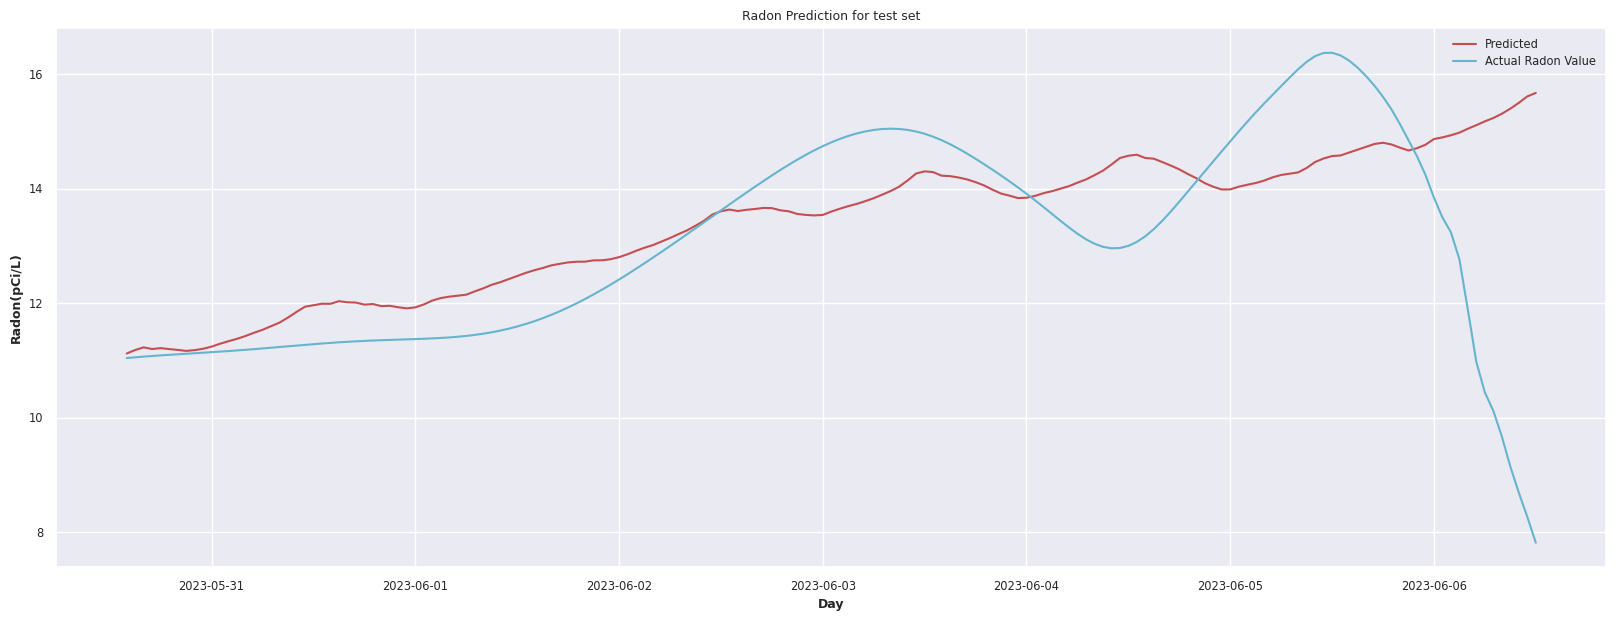

In [43]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()

# Radon 13

In [44]:
df = df_radon['13'].copy()

In [45]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [46]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [47]:
signal = df['Radon'].copy()
wavelet_name='coif17'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [48]:
weather_station = pd.read_csv('weather_data_combined.csv')

In [49]:
weather_station.drop('Date', axis=1, inplace=True)
weather_station['Simple Date'] = pd.to_datetime(weather_station['Simple Date'])
weather_station.sort_values(by='Simple Date', ascending=True, inplace=True)
weather_station['Simple Date'] = weather_station['Simple Date'].dt.floor('H')
weather_station = weather_station.resample('H', on = 'Simple Date').mean()
weather_station = weather_station.interpolate(method='linear', limit_direction='both')

In [50]:
weather_station

Outdoor h Temperature (°F)  Wind Speed (mph)  \
Simple Date                                                         
2022-05-10 00:00:00                       55.74              0.00   
2022-05-10 01:00:00                       54.79              0.00   
2022-05-10 02:00:00                       53.88              0.00   
2022-05-10 03:00:00                       52.49              0.00   
2022-05-10 04:00:00                       51.70              0.00   
...                                         ...               ...   
2023-06-07 19:00:00                       80.57              0.02   
2023-06-07 20:00:00                       77.16              0.00   
2023-06-07 21:00:00                       74.54              0.00   
2023-06-07 22:00:00                       73.51              0.06   
2023-06-07 23:00:00                       72.15              0.00   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
Simple Date                                                  
2022-05-10 00:00:00             0.00                  0.00   
2022-05-10 01:00:00             0.00                  0.00   
2022-05-10 02:00:00             0.00                  0.00   
2022-05-10 03:00:00             0.00                  0.00   
2022-05-10 04:00:00             0.00                  0.00   
...                              ...                   ...   
2023-06-07 19:00:00             0.18                  9.20   
2023-06-07 20:00:00             0.00                  9.20   
2023-06-07 21:00:00             0.00                  9.20   
2023-06-07 22:00:00             0.09                  9.20   
2023-06-07 23:00:00             0.00                  9.20   

                     Wind Direction (°)  Hourly Rain (in/hr)  Event Rain (in)  \
Simple Date                                                                     
2022-05-10 00:00:00              305.17                 0.00             0.00   
2022-05-10 01:00:00              302.58                 0.00             0.00   
2022-05-10 02:00:00              298.92                 0.00             0.00   
2022-05-10 03:00:00              302.92                 0.00             0.00   
2022-05-10 04:00:00              305.17                 0.00             0.00   
...                                 ...                  ...              ...   
2023-06-07 19:00:00              287.08                 0.00             0.00   
2023-06-07 20:00:00              309.83                 0.00             0.00   
2023-06-07 21:00:00              304.83                 0.00             0.00   
2023-06-07 22:00:00              307.83                 0.00             0.00   
2023-06-07 23:00:00              306.58                 0.00             0.00   

                     Daily Rain (in)  Weekly Rain (in)  Monthly Rain (in)  \
Simple Date                                                                 
2022-05-10 00:00:00             0.00              0.00               0.76   
2022-05-10 01:00:00             0.00              0.00               0.76   
2022-05-10 02:00:00             0.00              0.00               0.76   
2022-05-10 03:00:00             0.00              0.00               0.76   
2022-05-10 04:00:00             0.00              0.00               0.76   
...                              ...               ...                ...   
2023-06-07 19:00:00             0.00              0.02               0.02   
2023-06-07 20:00:00             0.00              0.02               0.02   
2023-06-07 21:00:00             0.00              0.02               0.02   
2023-06-07 22:00:00             0.00              0.02               0.02   
2023-06-07 23:00:00             0.00              0.02               0.02   

                     Yearly Rain (in)  Relative Pressure (inHg)  Humidity (%)  \
Simple Date                                                                     
2022-05-10 00:00:00             22.72                     29.13         90.67   
2022-05-10 01:00:

In [51]:
for column in weather_station.columns:
    df[column] = weather_station[column]

In [52]:
df

AirPressure  Humidity  Radon  Temperature  \
SyncDate                                                         
2022-05-11 19:00:00        30.07     62.00   5.31        76.00   
2022-05-11 20:00:00        30.07     66.00   5.17        75.00   
2022-05-11 21:00:00        30.07     70.00   5.02        73.00   
2022-05-11 22:00:00        30.08     73.00   4.87        71.00   
2022-05-11 23:00:00        30.11     72.00   4.70        70.00   
...                          ...       ...    ...          ...   
2023-06-06 08:00:00        30.01     87.00   5.77        68.00   
2023-06-06 09:00:00        30.00     85.00   5.71        71.00   
2023-06-06 10:00:00        30.01     77.00   5.64        80.00   
2023-06-06 11:00:00        29.98     74.71   5.55        79.14   
2023-06-06 12:00:00        29.94     72.43   5.44        78.29   

                     Outdoor h Temperature (°F)  Wind Speed (mph)  \
SyncDate                                                            
2022-05-11 19:00:00                       77.07              0.00   
2022-05-11 20:00:00                       74.87              0.00   
2022-05-11 21:00:00                       72.88              0.00   
2022-05-11 22:00:00                       71.14              0.00   
2022-05-11 23:00:00                       69.29              0.00   
...                                         ...               ...   
2023-06-06 08:00:00                       69.51              0.29   
2023-06-06 09:00:00                       76.43              0.43   
2023-06-06 10:00:00                       81.18              0.68   
2023-06-06 11:00:00                       83.35              0.57   
2023-06-06 12:00:00                       85.52              0.76   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
SyncDate                                                     
2022-05-11 19:00:00             0.09                  5.80   
2022-05-11 20:00:00             0.00                  5.80   
2022-05-11 21:00:00             0.00                  5.80   
2022-05-11 22:00:00             0.00                  5.80   
2022-05-11 23:00:00             0.00                  5.80   
...                              ...                   ...   
2023-06-06 08:00:00             1.03                  2.25   
2023-06-06 09:00:00             1.67                  4.80   
2023-06-06 10:00:00             2.05                  6.17   
2023-06-06 11:00:00             2.52                  6.90   
2023-06-06 12:00:00             2.33                  6.90   

                     Wind Direction (°)  Hourly Rain (in/hr)  ...  \
SyncDate                                                      ...   
2022-05-11 19:00:00              313.08                 0.00  ...   
2022-05-11 20:00:00              302.08                 0.00  ...   
2022-05-11 21:00:00              301.67                 0.00  ...   
2022-05-11 22:00:00              306.00                 0.00  ...   
2022-05-11 23:00:00              301.50                 0.00  ...   
...                                 ...                  ...  ...   
2023-06-06 08:00:00              307.83                 0.00  ...   
2023-06-06 09:00:00              317.17                 0.00  ...   
2023-06-06 10:00:00              308.50                 0.00  ...   
2023-06-06 11:00:00              287.25                 0.00  ...   
2023-06-06 12:00:00              303.50                 0.00  ...   

                     Weekly Rain (in)  Monthly Rain (in)  Yearly Rain (in)  \
SyncDate                                                                     
2022-05-11 19:00:00              0.00               0.76             22.72   
2022-05-11 20:00:00              0.00               0.76             22.72   
2022-05-11 21:00:00              0.00               0.76             22.72   
2022-05-11 22:00:00              0.00               0.76             22.72   
2022-05-11 23:00:00              0.00               0.76             22.72   
...          

In [53]:
df.dropna(inplace=True)

In [54]:
df

AirPressure  Humidity  Radon  Temperature  \
SyncDate                                                         
2022-05-11 19:00:00        30.07     62.00   5.31        76.00   
2022-05-11 20:00:00        30.07     66.00   5.17        75.00   
2022-05-11 21:00:00        30.07     70.00   5.02        73.00   
2022-05-11 22:00:00        30.08     73.00   4.87        71.00   
2022-05-11 23:00:00        30.11     72.00   4.70        70.00   
...                          ...       ...    ...          ...   
2023-06-06 08:00:00        30.01     87.00   5.77        68.00   
2023-06-06 09:00:00        30.00     85.00   5.71        71.00   
2023-06-06 10:00:00        30.01     77.00   5.64        80.00   
2023-06-06 11:00:00        29.98     74.71   5.55        79.14   
2023-06-06 12:00:00        29.94     72.43   5.44        78.29   

                     Outdoor h Temperature (°F)  Wind Speed (mph)  \
SyncDate                                                            
2022-05-11 19:00:00                       77.07              0.00   
2022-05-11 20:00:00                       74.87              0.00   
2022-05-11 21:00:00                       72.88              0.00   
2022-05-11 22:00:00                       71.14              0.00   
2022-05-11 23:00:00                       69.29              0.00   
...                                         ...               ...   
2023-06-06 08:00:00                       69.51              0.29   
2023-06-06 09:00:00                       76.43              0.43   
2023-06-06 10:00:00                       81.18              0.68   
2023-06-06 11:00:00                       83.35              0.57   
2023-06-06 12:00:00                       85.52              0.76   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
SyncDate                                                     
2022-05-11 19:00:00             0.09                  5.80   
2022-05-11 20:00:00             0.00                  5.80   
2022-05-11 21:00:00             0.00                  5.80   
2022-05-11 22:00:00             0.00                  5.80   
2022-05-11 23:00:00             0.00                  5.80   
...                              ...                   ...   
2023-06-06 08:00:00             1.03                  2.25   
2023-06-06 09:00:00             1.67                  4.80   
2023-06-06 10:00:00             2.05                  6.17   
2023-06-06 11:00:00             2.52                  6.90   
2023-06-06 12:00:00             2.33                  6.90   

                     Wind Direction (°)  Hourly Rain (in/hr)  ...  \
SyncDate                                                      ...   
2022-05-11 19:00:00              313.08                 0.00  ...   
2022-05-11 20:00:00              302.08                 0.00  ...   
2022-05-11 21:00:00              301.67                 0.00  ...   
2022-05-11 22:00:00              306.00                 0.00  ...   
2022-05-11 23:00:00              301.50                 0.00  ...   
...                                 ...                  ...  ...   
2023-06-06 08:00:00              307.83                 0.00  ...   
2023-06-06 09:00:00              317.17                 0.00  ...   
2023-06-06 10:00:00              308.50                 0.00  ...   
2023-06-06 11:00:00              287.25                 0.00  ...   
2023-06-06 12:00:00              303.50                 0.00  ...   

                     Weekly Rain (in)  Monthly Rain (in)  Yearly Rain (in)  \
SyncDate                                                                     
2022-05-11 19:00:00              0.00               0.76             22.72   
2022-05-11 20:00:00              0.00               0.76             22.72   
2022-05-11 21:00:00              0.00               0.76             22.72   
2022-05-11 22:00:00              0.00               0.76             22.72   
2022-05-11 23:00:00              0.00               0.76             22.72   
...          

In [55]:
# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")
gaps(df)

no missing values



In [56]:
df.describe()

AirPressure  Humidity   Radon  Temperature  Outdoor h Temperature (°F)  \
count      9378.00   9378.00 9378.00      9378.00                     9378.00   
mean         30.09     82.47    8.81        66.32                       62.98   
std           0.14     14.90   12.58        16.32                       14.85   
min          29.52     23.00   -1.36        16.00                        7.12   
25%          30.00     75.00    1.22        54.00                       52.55   
50%          30.09     88.00    4.38        67.00                       64.87   
75%          30.18     94.00   12.80        76.52                       73.89   
max          30.62    100.00  135.58       137.00                       98.02   

       Wind Speed (mph)  Wind Gust (mph)  Max Daily Gust (mph)  \
count           9378.00          9378.00               9378.00   
mean               0.23             0.90                  4.70   
std                0.37             1.15                  3.49   
min                0.00             0.00                  0.00   
25%                0.00             0.00                  1.48   
50%                0.03             0.37                  4.50   
75%                0.34             1.56                  6.90   
max                5.35             8.02                 20.60   

       Wind Direction (°)  Hourly Rain (in/hr)  ...  Weekly Rain (in)  \
count             9378.00              9378.00  ...           9378.00   
mean               297.71                 0.01  ...              0.54   
std                 28.84                 0.04  ...              0.85   
min                  1.33                 0.00  ...              0.00   
25%                289.00                 0.00  ...              0.00   
50%                305.58                 0.00  ...              0.09   
75%                316.08                 0.00  ...              0.72   
max                347.67                 1.23  ...              3.90   

       Monthly Rain (in)  Yearly Rain (in)  Relative Pressure (inHg)  \
count            9378.00           9378.00                   9378.00   
mean                2.88             52.63                     29.02   
std                 2.98             18.94                      0.14   
min                 0.00             22.72                     28.40   
25%                 0.76             37.85                     28.93   
50%                 2.14             47.13                     29.02   
75%                 3.72             69.48                     29.11   
max                14.68             83.42                     29.51   

       Humidity (%)  Ultra-Violet Radiation Index  Solar Radiation (W/m^2)  \
count       9378.00                       9378.00                  9378.00   
mean          76.37                          0.96                   119.51   
std           17.72                          1.79                   200.38   
min           17.17                          0.00                     0.00   
25%           65.00                          0.00                     0.00   
50%           79.92                          0.00                     2.59   
75%           91.58                          1.00                   144.45   
max           99.00                          8.00                   872.65   

       Absolute Pressure (inHg)  Avg Wind Direction (10 mins) (°)  \
count                   9378.00                           9378.00   
mean                      29.02                            308.30   
std                        0.14                             18.81   
min                       28.40                              1.42   
25%                       28.93                            302.17   
50%                       29.02                            311.08   
75%                       29.11                            318.75   
max                       29.51                            348.08   

       Avg Wind Speed (10 mins) (mph)  
count     

In [57]:
for column in df.columns:
    df[column] = df[column].astype('float32')
    if column == 'Radon':
        continue
    else:
        for i in range(1,40):
            df[column+'_lag_'+str(i)] = df[column].shift(i)

In [58]:
df.fillna(0, inplace=True)

In [59]:
# check correlations of features with price
df_corr = df.corr(method="spearman")
print(df_corr.shape)
print("correlation with Radon:")
df_corrP = pd.DataFrame(df_corr["Radon"].sort_values(ascending=False))
df_corrP

(841, 841)
correlation with Radon:


Radon
Radon                     1.00
Temperature_lag_17        0.54
Temperature_lag_18        0.54
Temperature_lag_16        0.54
Temperature               0.54
...                        ...
Yearly Rain (in)_lag_35  -0.64
Yearly Rain (in)_lag_36  -0.64
Yearly Rain (in)_lag_37  -0.64
Yearly Rain (in)_lag_38  -0.64
Yearly Rain (in)_lag_39  -0.64

[841 rows x 1 columns]

In [60]:
# highest absolute correlations with Radon
pd.options.display.float_format = '{:,.2f}'.format
df_corrH = df_corrP[(df_corrP["Radon"]) >= 0.54103]
df_corrH

Radon
Radon                1.00
Temperature_lag_17   0.54

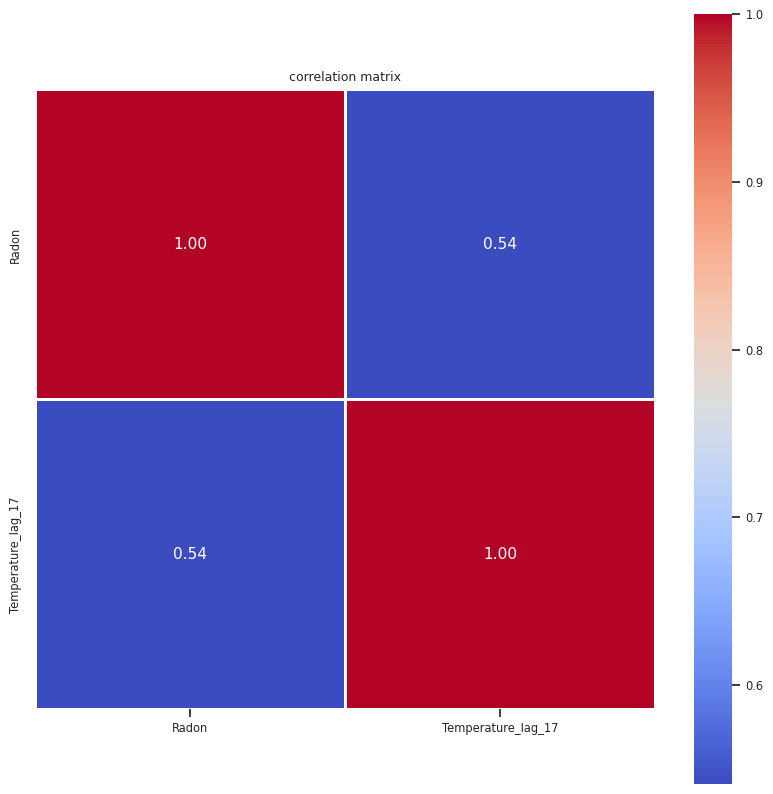

In [61]:
# helper method: correlation matrix as heatmap
def corr_heatmap(df):
    idx = df.corr().sort_values("Radon", ascending=False).index
    df_sorted = df.loc[:, idx]  # sort dataframe columns by their correlation 

    #plt.figure(figsize = (15,15))
    sns.set(font_scale=0.75)
    ax = sns.heatmap(df_sorted.corr(method='spearman').round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap="coolwarm", 
            fmt = ".2f", 
            annot_kws = {"size": 11})
    ax.xaxis.tick_bottom()
    plt.title("correlation matrix")
    plt.show()



# visualize correlations with price     

df4 = df[df_corrH.index]   # keep the components with at least modest correlations

plt.figure(figsize = (10,10))
corr_heatmap(df4)

In [62]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9378 entries, 2022-05-11 19:00:00 to 2023-06-06 12:00:00
Freq: H
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Radon               9378 non-null   float32
 1   Temperature_lag_17  9378 non-null   float32
dtypes: float32(2)
memory usage: 146.5 KB


In [63]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df4["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [64]:
# create time series object for the feature columns
df_covF = df4.loc[:, df4.columns != "Radon"]
df_covF = df_covF.loc[:, df_covF.columns != 'Outdoor h Temperature (°F)']
ts_covF = TimeSeries.from_dataframe(df_covF, fill_missing_dates=True, freq="H")

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['Temperature_lag_17'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [65]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(9378, 1, 1)

In [66]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [67]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(9378, 1, 1)

In [68]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [69]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-06-06 12:00:00   0.05

In [70]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(split_point=9210)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  
# covF_t = ts_covF
# covF_ttrain = covF_train
# covF_ttest = covF_test
# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component            Temperature_lag_17
SyncDate                               
2022-05-11 19:00:00                0.00
2023-06-06 12:00:00                0.55

In [71]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-05-30 13:00:00   0.03

In [72]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_rnn_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None


    model = RNNModel(
        model=model_args['model'],
        input_chunk_length=model_args['in_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name=f"{model_args['model']} RNN model",
        n_rnn_layers=model_args['n_rnn_layers'],
        training_length=model_args['in_len']+20,
        hidden_dim=model_args['hidden_dim'],
        dropout=model_args['dropout'],
        loss_fn=SmapeLoss(),
#         likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42,
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                future_covariates=covF_t,
                val_series=val_series,
                val_future_covariates=covF_t,)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                future_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [73]:
def build_fit_rnn_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices":1,
            'callbacks': callbacks,
        }
    encoders={"cyclic": {"future": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None


    model = RNNModel(
        model=model_args['model'],
        input_chunk_length=model_args['in_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name=f"{model_args['model']} RNN model return",
        n_rnn_layers=model_args['n_rnn_layers'],
        training_length=model_args['in_len']+20,
        hidden_dim=model_args['hidden_dim'],
        dropout=model_args['dropout'],
        loss_fn=SmapeLoss(),
#         likelihood=QuantileRegression(quantiles=QUANTILES),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                future_covariates=covF_t,
                val_series=val_series,
                val_future_covariates=covF_t,)
#     if save_model:
#         print("have saved the model after training:", mpath)
#         model.save_model(mpath)
    return model

In [74]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "batch_size": tune.choice([32,64,128]),
    "in_len": tune.randint(1,40),
    "dropout":tune.uniform(0.1,0.5),
    "model":tune.choice(['RNN','LSTM','GRU']),
    "hidden_dim":tune.randint(1,32),
    "n_rnn_layers":tune.randint(1,3),
    "lr":tune.loguniform(1e-5,1e-1),
    "include_hour":tune.choice([True,False]),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_rnn_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="rnn_tune_cov",

)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-07 22:35:16 (running for 00:00:00.15)
Memory usage on this node: 7.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 1/100 (1 RUNNING)
+------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+
| Trial name                   | status   | loc                 |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |          lr | include_hour   |
|------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------|
| build_fit_rnn_model

(build_fit_rnn_model pid=976263) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.43289899049218383 and num_layers=1
(build_fit_rnn_model pid=976263)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=976263) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=976263)   rank_zero_deprecation(
(build_fit_rnn_model pid=976263) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:35:26 (running for 00:00:09.50)
Memory usage on this node: 13.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+
| Trial name                   | status   | loc                 |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |          lr | include_hour   |
|------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+-----------

(build_fit_rnn_model pid=976548) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=976548)   rank_zero_deprecation(
(build_fit_rnn_model pid=976548) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=976548)   rank_zero_deprecation(
(build_fit_rnn_model pid=976493) Auto select gpus: [0]
(build_fit_rnn_model pid=976493) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=976493) TPU available: False, using: 0 TP

(build_fit_rnn_model pid=976486) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=976486) 
(build_fit_rnn_model pid=976486)   | Name          | Type             | Params
(build_fit_rnn_model pid=976486) ---------------------------------------------------
(build_fit_rnn_model pid=976486) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=976486) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=976486) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=976486) 3 | rnn           | GRU              | 2.1 K 
(build_fit_rnn_model pid=976486) 4 | V             | Linear           | 15    
(build_fit_rnn_model pid=976486) ---------------------------------------------------
(build_fit_rnn_model pid=976486) 2.1 K     Trainable params
(build_fit_rnn_model pid=976486) 0         Non-trainable params
(build_fit_rnn_model pid=976486) 2.1 K     Total params
(build_fit_rnn_model pid=976486) 0.008     Total estimated model pa

(build_fit_rnn_model pid=976490) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=976490)   rank_zero_warn(
(build_fit_rnn_model pid=976490) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=976490)   rank_zero_warn(
(build_fit_rnn_model pid=976488) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logge

== Status ==
Current time: 2023-07-07 22:35:31 (running for 00:00:14.51)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+
| Trial name                   | status   | loc                 |   batch_size |   in_len |   dropout | model   |   hidden_dim |   n_rnn_layers |          lr | include_hour   |
|------------------------------+----------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+-----------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.71it/s]


(build_fit_rnn_model pid=976495) Auto select gpus: [0]
(build_fit_rnn_model pid=976495) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=976495) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=976495) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=976495) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=976495) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=976495) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=976548) Auto select gpus: [0]
(build_fit_rnn_model pid=976548) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=976548) TPU available: False, using: 0 TPU cores


== Status ==
Current time: 2023-07-07 22:35:47 (running for 00:00:31.21)
Memory usage on this node: 24.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 067e64dc with q_smape=183.3633303642273 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.1763413764363082, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 1, 'lr': 0.013881124037506963, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batc

(build_fit_rnn_model pid=978112) Auto select gpus: [0]
(build_fit_rnn_model pid=978112) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=978112) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=978112) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=978112) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=978112) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=978114) Auto select gpus: [0]
(build_fit_rnn_model pid=978114) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=978114) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=978114) IPU available: False, using: 0 IPUs
(build

== Status ==
Current time: 2023-07-07 22:35:52 (running for 00:00:36.22)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 067e64dc with q_smape=183.3633303642273 and parameters={'batch_size': 64, 'in_len': 26, 'dropout': 0.1763413764363082, 'model': 'LSTM', 'hidden_dim': 22, 'n_rnn_layers': 1, 'lr': 0.013881124037506963, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batc

(build_fit_rnn_model pid=976486) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=976486)   rank_zero_deprecation(
(build_fit_rnn_model pid=976486) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=976486)   rank_zero_deprecation(
(build_fit_rnn_model pid=976486) Auto select gpus: [0]
(build_fit_rnn_model pid=976486) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=976486) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.36it/s]


(build_fit_rnn_model pid=978579) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=978579)   rank_zero_deprecation(
(build_fit_rnn_model pid=978579) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=978579)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:36:01 (running for 00:00:45.20)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 713a033b with q_smape=131.23563528060913 and parameters={'batch_size': 32, 'in_len': 35, 'dropout': 0.4885440259973062, 'model': 'GRU', 'hidden_dim': 14, 'n_rnn_layers': 2, 'lr': 0.0689383485622592, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_s

(build_fit_rnn_model pid=978579) Auto select gpus: [0]
(build_fit_rnn_model pid=978579) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=978579) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=978579) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=978579) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=978579) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=978579) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=978579) 
(build_fit_rnn_model pid=978579)   | Name          | Type             | Params
(build_fit_rnn_model pid=978579) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.34it/s]


(build_fit_rnn_model pid=976499) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=976499)   rank_zero_deprecation(
(build_fit_rnn_model pid=976499) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=976499)   rank_zero_deprecation(
(build_fit_rnn_model pid=976499) Auto select gpus: [0]
(build_fit_rnn_model pid=976499) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=976499) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:36:11 (running for 00:00:54.79)
Memory usage on this node: 26.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 13/100 (1 PENDING, 8 RUNNING, 4 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_

(build_fit_rnn_model pid=976263) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=976263)   rank_zero_deprecation(
(build_fit_rnn_model pid=976263) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=976263)   rank_zero_deprecation(
(build_fit_rnn_model pid=976263) Auto select gpus: [0]
(build_fit_rnn_model pid=976263) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=976263) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.00it/s]


(build_fit_rnn_model pid=978816) Auto select gpus: [0]
(build_fit_rnn_model pid=978816) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=978816) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=978816) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=978816) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=978816) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=978816) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=978816) 
(build_fit_rnn_model pid=978816)   | Name          | Type             | Params
(build_fit_rnn_model pid=978816) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:36:16 (running for 00:01:00.20)
Memory usage on this node: 26.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_

(build_fit_rnn_model pid=979048) Auto select gpus: [0]
(build_fit_rnn_model pid=979048) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=979048) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=979048) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=979048) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=979048) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=979048) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=979048) 
(build_fit_rnn_model pid=979048)   | Name          | Type             | Params
(build_fit_rnn_model pid=979048) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:36:21 (running for 00:01:05.21)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=976490) Auto select gpus: [0]
(build_fit_rnn_model pid=976490) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=976490) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=976490) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=976490) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=976490) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=976490) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.51it/s]


(build_fit_rnn_model pid=978112) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=978112)   rank_zero_deprecation(
(build_fit_rnn_model pid=978112) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=978112)   rank_zero_deprecation(
(build_fit_rnn_model pid=978112) Auto select gpus: [0]
(build_fit_rnn_model pid=978112) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=978112) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.08it/s]


(build_fit_rnn_model pid=979048) Auto select gpus: [0]
(build_fit_rnn_model pid=979048) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=979048) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=979048) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=979048) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=979048) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=979048) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=978114) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.79it/s]


(build_fit_rnn_model pid=978816) Auto select gpus: [0]
(build_fit_rnn_model pid=978816) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=978816) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=978816) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=978816) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=978816) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=978816) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=979302) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero 

== Status ==
Current time: 2023-07-07 22:36:33 (running for 00:01:16.51)
Memory usage on this node: 21.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_

(build_fit_rnn_model pid=979302) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=979302) 
(build_fit_rnn_model pid=979302)   | Name          | Type             | Params
(build_fit_rnn_model pid=979302) ---------------------------------------------------
(build_fit_rnn_model pid=979302) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=979302) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=979302) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=979302) 3 | rnn           | GRU              | 1.7 K 
(build_fit_rnn_model pid=979302) 4 | V             | Linear           | 22    
(build_fit_rnn_model pid=979302) ---------------------------------------------------
(build_fit_rnn_model pid=979302) 1.7 K     Trainable params
(build_fit_rnn_model pid=979302) 0         Non-trainable params
(build_fit_rnn_model pid=979302) 1.7 K     Total params
(build_fit_rnn_model pid=979302) 0.007     Total estimated model pa

(build_fit_rnn_model pid=979614) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=979614)   rank_zero_warn(
(build_fit_rnn_model pid=979614) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_rnn_model pid=979614)   rank_zero_warn(
(build_fit_rnn_model pid=980003) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(acceler

== Status ==
Current time: 2023-07-07 22:36:41 (running for 00:01:25.25)
Memory usage on this node: 24.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 19/100 (1 PENDING, 8 RUNNING, 10 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=980003) Auto select gpus: [0]
(build_fit_rnn_model pid=980003) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=980003) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=980003) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=980003) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=980003) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=980005) Auto select gpus: [0]
(build_fit_rnn_model pid=980005) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=980005) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=980005) IPU available: False, using: 0 IPUs
(build

== Status ==
Current time: 2023-07-07 22:36:46 (running for 00:01:30.26)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 19/100 (1 PENDING, 8 RUNNING, 10 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=979614) Auto select gpus: [0]
(build_fit_rnn_model pid=979614) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=979614) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=979614) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=979614) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=979614) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=979614) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.72it/s]


(build_fit_rnn_model pid=979302) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=979302)   rank_zero_deprecation(
(build_fit_rnn_model pid=979302) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=979302)   rank_zero_deprecation(
(build_fit_rnn_model pid=979302) Auto select gpus: [0]
(build_fit_rnn_model pid=979302) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=979302) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:36:52 (running for 00:01:36.20)
Memory usage on this node: 25.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 19/100 (8 RUNNING, 11 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   i

(build_fit_rnn_model pid=980476) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.327461408103285 and num_layers=1
(build_fit_rnn_model pid=980476)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=980476) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=980476)   rank_zero_deprecation(
(build_fit_rnn_model pid=980476) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been 

== Status ==
Current time: 2023-07-07 22:37:02 (running for 00:01:46.22)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=980005) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=980005)   rank_zero_deprecation(
(build_fit_rnn_model pid=980005) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=980005)   rank_zero_deprecation(
(build_fit_rnn_model pid=980005) Auto select gpus: [0]
(build_fit_rnn_model pid=980005) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=980005) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:37:08 (running for 00:01:51.73)
Memory usage on this node: 26.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=980003) Auto select gpus: [0]
(build_fit_rnn_model pid=980003) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=980003) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=980003) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=980003) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=980003) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=980003) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=980946) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero 

== Status ==
Current time: 2023-07-07 22:37:13 (running for 00:01:57.22)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=981181) Auto select gpus: [0]
(build_fit_rnn_model pid=981181) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=981181) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=981181) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=981181) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=981181) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=981181) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=981181) 
(build_fit_rnn_model pid=981181)   | Name          | Type             | Params
(build_fit_rnn_model pid=981181) ---------------------------------------------------
(bu

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=976488) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=976488)   rank_zero_deprecation(
(build_fit_rnn_model pid=976488) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=976488)   rank_zero_deprecation(
(build_fit_rnn_model pid=976488) Auto select gpus: [0]
(build_fit_rnn_model pid=976488) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=976488) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.55it/s]


(build_fit_rnn_model pid=981427) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.43223198310861377 and num_layers=1
(build_fit_rnn_model pid=981427)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=981427) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=981427)   rank_zero_deprecation(
(build_fit_rnn_model pid=981427) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:37:23 (running for 00:02:07.23)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=981427) Auto select gpus: [0]
(build_fit_rnn_model pid=981427) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=981427) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=981427) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=981427) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=981427) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=981427) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=981427) 
(build_fit_rnn_model pid=981427)   | Name          | Type             | Params
(build_fit_rnn_model pid=981427) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:37:28 (running for 00:02:12.24)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

== Status ==
Current time: 2023-07-07 22:37:38 (running for 00:02:22.25)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

== Status ==
Current time: 2023-07-07 22:37:48 (running for 00:02:32.26)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

== Status ==
Current time: 2023-07-07 22:37:58 (running for 00:02:42.28)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

== Status ==
Current time: 2023-07-07 22:38:08 (running for 00:02:52.29)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=981427) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=981427)   rank_zero_deprecation(
(build_fit_rnn_model pid=981427) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=981427)   rank_zero_deprecation(
(build_fit_rnn_model pid=981427) Auto select gpus: [0]
(build_fit_rnn_model pid=981427) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=981427) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.39it/s]


(build_fit_rnn_model pid=981673) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4381903631659751 and num_layers=1
(build_fit_rnn_model pid=981673)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=981673) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=981673)   rank_zero_deprecation(
(build_fit_rnn_model pid=981673) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been

== Status ==
Current time: 2023-07-07 22:38:18 (running for 00:03:02.23)
Memory usage on this node: 25.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=981834) Auto select gpus: [0]
(build_fit_rnn_model pid=981834) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=981834) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=981834) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=981834) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=981834) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=981673) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=981673) 
(build_fit_rnn_model pid=981673)   | Name          | Type             | Params
(build_fit_rnn_model pid=981673) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.89it/s]


(build_fit_rnn_model pid=980709) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=980709)   rank_zero_deprecation(
(build_fit_rnn_model pid=980709) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=980709)   rank_zero_deprecation(
(build_fit_rnn_model pid=980709) Auto select gpus: [0]
(build_fit_rnn_model pid=980709) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=980709) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:38:28 (running for 00:03:12.24)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=982147) Auto select gpus: [0]
(build_fit_rnn_model pid=982147) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=982147) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=982147) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=982147) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=982147) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=982147) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=982147) 
(build_fit_rnn_model pid=982147)   | Name          | Type             | Params
(build_fit_rnn_model pid=982147) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.64it/s]


(build_fit_rnn_model pid=976493) Auto select gpus: [0]
(build_fit_rnn_model pid=976493) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=976493) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=976493) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=976493) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=976493) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=976493) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=982385) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero 

== Status ==
Current time: 2023-07-07 22:38:38 (running for 00:03:22.23)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=982385) Auto select gpus: [0]
(build_fit_rnn_model pid=982385) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=982385) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=982385) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=982385) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=982385) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=982385) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=982385) 
(build_fit_rnn_model pid=982385)   | Name          | Type             | Params
(build_fit_rnn_model pid=982385) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:38:43 (running for 00:03:27.24)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

== Status ==
Current time: 2023-07-07 22:38:53 (running for 00:03:37.26)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.66it/s]


(build_fit_rnn_model pid=980946) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=980946)   rank_zero_deprecation(
(build_fit_rnn_model pid=980946) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=980946)   rank_zero_deprecation(
(build_fit_rnn_model pid=980946) Auto select gpus: [0]
(build_fit_rnn_model pid=980946) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=980946) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:39:06 (running for 00:03:50.25)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=982627) Auto select gpus: [0]
(build_fit_rnn_model pid=982627) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=982627) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=982627) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=982627) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=982627) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=982627) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=982627) 
(build_fit_rnn_model pid=982627)   | Name          | Type             | Params
(build_fit_rnn_model pid=982627) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:39:11 (running for 00:03:55.26)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=982147) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=982147)   rank_zero_deprecation(
(build_fit_rnn_model pid=982147) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=982147)   rank_zero_deprecation(
(build_fit_rnn_model pid=982147) Auto select gpus: [0]
(build_fit_rnn_model pid=982147) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=982147) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:39:18 (running for 00:04:02.25)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=982866) Auto select gpus: [0]
(build_fit_rnn_model pid=982866) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=982866) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=982866) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=982866) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=982866) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=982866) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=982866) 
(build_fit_rnn_model pid=982866)   | Name          | Type             | Params
(build_fit_rnn_model pid=982866) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:39:23 (running for 00:04:07.26)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch

(build_fit_rnn_model pid=982627) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=982627)   rank_zero_deprecation(
(build_fit_rnn_model pid=982627) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=982627)   rank_zero_deprecation(
(build_fit_rnn_model pid=982627) Auto select gpus: [0]
(build_fit_rnn_model pid=982627) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=982627) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:39:29 (running for 00:04:13.22)
Memory usage on this node: 25.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 0a5b7311 with q_smape=34.0737521648407 and parameters={'batch_size': 32, 'in_len': 7, 'dropout': 0.43289899049218383, 'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'lr': 0.0005183015125701119, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 30/100 (8 RUNNING, 22 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   i

(build_fit_rnn_model pid=983105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.41449248591248106 and num_layers=1
(build_fit_rnn_model pid=983105)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=983105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=983105)   rank_zero_deprecation(
(build_fit_rnn_model pid=983105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.08it/s]


(build_fit_rnn_model pid=979300) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=979300)   rank_zero_deprecation(
(build_fit_rnn_model pid=979300) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=979300)   rank_zero_deprecation(
(build_fit_rnn_model pid=979300) Auto select gpus: [0]
(build_fit_rnn_model pid=979300) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=979300) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:39:37 (running for 00:04:20.94)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=982385) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=982385)   rank_zero_deprecation(
(build_fit_rnn_model pid=982385) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=982385)   rank_zero_deprecation(
(build_fit_rnn_model pid=982385) Auto select gpus: [0]
(build_fit_rnn_model pid=982385) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=982385) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:39:45 (running for 00:04:29.24)
Memory usage on this node: 26.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=983504) Auto select gpus: [0]
(build_fit_rnn_model pid=983504) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=983504) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=983504) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=983504) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=983504) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=983504) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=983504) 
(build_fit_rnn_model pid=983504)   | Name          | Type             | Params
(build_fit_rnn_model pid=983504) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:39:50 (running for 00:04:34.25)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:40:00 (running for 00:04:44.27)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


(build_fit_rnn_model pid=980476) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=980476)   rank_zero_deprecation(
(build_fit_rnn_model pid=980476) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=980476)   rank_zero_deprecation(
(build_fit_rnn_model pid=980476) Auto select gpus: [0]
(build_fit_rnn_model pid=980476) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=980476) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:40:11 (running for 00:04:55.25)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=983863) Auto select gpus: [0]
(build_fit_rnn_model pid=983863) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=983863) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=983863) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=983863) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=983863) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=983863) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=983863) 
(build_fit_rnn_model pid=983863)   | Name          | Type             | Params
(build_fit_rnn_model pid=983863) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:40:16 (running for 00:05:00.26)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:40:26 (running for 00:05:10.27)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=982866) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=982866)   rank_zero_deprecation(
(build_fit_rnn_model pid=982866) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=982866)   rank_zero_deprecation(
(build_fit_rnn_model pid=982866) Auto select gpus: [0]
(build_fit_rnn_model pid=982866) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=982866) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.48it/s]


(build_fit_rnn_model pid=984103) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.398133181734938 and num_layers=1
(build_fit_rnn_model pid=984103)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=984103) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=984103)   rank_zero_deprecation(
(build_fit_rnn_model pid=984103) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been 

== Status ==
Current time: 2023-07-07 22:40:33 (running for 00:05:17.25)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=984103) Auto select gpus: [0]
(build_fit_rnn_model pid=984103) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=984103) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=984103) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=984103) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=984103) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=984103) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=984103) 
(build_fit_rnn_model pid=984103)   | Name          | Type             | Params
(build_fit_rnn_model pid=984103) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:40:38 (running for 00:05:22.26)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=983504) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=983504)   rank_zero_deprecation(
(build_fit_rnn_model pid=983504) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=983504)   rank_zero_deprecation(
(build_fit_rnn_model pid=983504) Auto select gpus: [0]
(build_fit_rnn_model pid=983504) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=983504) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:40:45 (running for 00:05:29.25)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=984342) Auto select gpus: [0]
(build_fit_rnn_model pid=984342) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=984342) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=984342) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=984342) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=984342) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=984342) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=984342) 
(build_fit_rnn_model pid=984342)   | Name          | Type             | Params
(build_fit_rnn_model pid=984342) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:40:50 (running for 00:05:34.26)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=981834) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=981834)   rank_zero_deprecation(
(build_fit_rnn_model pid=981834) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=981834)   rank_zero_deprecation(
(build_fit_rnn_model pid=981834) Auto select gpus: [0]
(build_fit_rnn_model pid=981834) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=981834) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.68it/s]


(build_fit_rnn_model pid=984581) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3581386207732988 and num_layers=1
(build_fit_rnn_model pid=984581)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=984581) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=984581)   rank_zero_deprecation(
(build_fit_rnn_model pid=984581) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been

== Status ==
Current time: 2023-07-07 22:40:59 (running for 00:05:43.26)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=984581) Auto select gpus: [0]
(build_fit_rnn_model pid=984581) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=984581) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=984581) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=984581) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=984581) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=984581) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=984581) 
(build_fit_rnn_model pid=984581)   | Name          | Type             | Params
(build_fit_rnn_model pid=984581) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:41:04 (running for 00:05:48.26)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:41:14 (running for 00:05:58.28)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8feca96c with q_smape=33.50234925746918 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.22963486240598857, 'model': 'RNN', 'hidden_dim': 6, 'n_rnn_layers': 1, 'lr': 1.9814130337983567e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=983863) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=983863)   rank_zero_deprecation(
(build_fit_rnn_model pid=983863) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=983863)   rank_zero_deprecation(
(build_fit_rnn_model pid=983863) Auto select gpus: [0]
(build_fit_rnn_model pid=983863) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=983863) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:41:21 (running for 00:06:05.26)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ac2d6115 with q_smape=29.912996292114258 and parameters={'batch_size': 32, 'in_len': 39, 'dropout': 0.3804824093564204, 'model': 'RNN', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 4.3375229567857634e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=984821) Auto select gpus: [0]
(build_fit_rnn_model pid=984821) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=984821) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=984821) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=984821) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=984821) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=984821) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=984821) 
(build_fit_rnn_model pid=984821)   | Name          | Type             | Params
(build_fit_rnn_model pid=984821) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:41:26 (running for 00:06:10.26)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ac2d6115 with q_smape=29.912996292114258 and parameters={'batch_size': 32, 'in_len': 39, 'dropout': 0.3804824093564204, 'model': 'RNN', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 4.3375229567857634e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:41:36 (running for 00:06:20.28)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: ac2d6115 with q_smape=29.912996292114258 and parameters={'batch_size': 32, 'in_len': 39, 'dropout': 0.3804824093564204, 'model': 'RNN', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 4.3375229567857634e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=981673) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=981673)   rank_zero_deprecation(
(build_fit_rnn_model pid=981673) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=981673)   rank_zero_deprecation(
(build_fit_rnn_model pid=981673) Auto select gpus: [0]
(build_fit_rnn_model pid=981673) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=981673) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.12it/s]
== Status ==
Current time: 2023-07-07 22:41:42 (running for 00:06:26.24)
Memory usage on this node: 25.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 78fba65c with q_smape=28.71011793613434 and parameters={'batch_size': 32, 'in_len': 1, 'dropout': 0.4381903631659751, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.00023099997736317695, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 38/100 (8 RUNNING, 30 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name  

(build_fit_rnn_model pid=985062) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3683197923833673 and num_layers=1
(build_fit_rnn_model pid=985062)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=985062) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=985062)   rank_zero_deprecation(
(build_fit_rnn_model pid=985062) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been

== Status ==
Current time: 2023-07-07 22:41:52 (running for 00:06:35.71)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 78fba65c with q_smape=28.71011793613434 and parameters={'batch_size': 32, 'in_len': 1, 'dropout': 0.4381903631659751, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.00023099997736317695, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batc

== Status ==
Current time: 2023-07-07 22:42:02 (running for 00:06:45.73)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 78fba65c with q_smape=28.71011793613434 and parameters={'batch_size': 32, 'in_len': 1, 'dropout': 0.4381903631659751, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.00023099997736317695, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batc

(build_fit_rnn_model pid=984103) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=984103)   rank_zero_deprecation(
(build_fit_rnn_model pid=984103) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=984103)   rank_zero_deprecation(
(build_fit_rnn_model pid=984103) Auto select gpus: [0]
(build_fit_rnn_model pid=984103) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=984103) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.62it/s]


(build_fit_rnn_model pid=985308) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.38273856885021945 and num_layers=1
(build_fit_rnn_model pid=985308)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=985308) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=985308)   rank_zero_deprecation(
(build_fit_rnn_model pid=985308) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:42:11 (running for 00:06:55.27)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 78fba65c with q_smape=28.71011793613434 and parameters={'batch_size': 32, 'in_len': 1, 'dropout': 0.4381903631659751, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.00023099997736317695, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batc

(build_fit_rnn_model pid=985308) Auto select gpus: [0]
(build_fit_rnn_model pid=985308) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=985308) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=985308) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=985308) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=985308) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=985308) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=985308) 
(build_fit_rnn_model pid=985308)   | Name          | Type             | Params
(build_fit_rnn_model pid=985308) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:42:16 (running for 00:07:00.27)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 78fba65c with q_smape=28.71011793613434 and parameters={'batch_size': 32, 'in_len': 1, 'dropout': 0.4381903631659751, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.00023099997736317695, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batc

(build_fit_rnn_model pid=984342) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=984342)   rank_zero_deprecation(
(build_fit_rnn_model pid=984342) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=984342)   rank_zero_deprecation(
(build_fit_rnn_model pid=984342) Auto select gpus: [0]
(build_fit_rnn_model pid=984342) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=984342) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:42:22 (running for 00:07:06.25)
Memory usage on this node: 25.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 78fba65c with q_smape=28.71011793613434 and parameters={'batch_size': 32, 'in_len': 1, 'dropout': 0.4381903631659751, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.00023099997736317695, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 40/100 (8 RUNNING, 32 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   

(build_fit_rnn_model pid=985546) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.47080738911517955 and num_layers=1
(build_fit_rnn_model pid=985546)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=985546) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=985546)   rank_zero_deprecation(
(build_fit_rnn_model pid=985546) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:42:32 (running for 00:07:15.72)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 78fba65c with q_smape=28.71011793613434 and parameters={'batch_size': 32, 'in_len': 1, 'dropout': 0.4381903631659751, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.00023099997736317695, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batc

(build_fit_rnn_model pid=984581) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=984581)   rank_zero_deprecation(
(build_fit_rnn_model pid=984581) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=984581)   rank_zero_deprecation(
(build_fit_rnn_model pid=984581) Auto select gpus: [0]
(build_fit_rnn_model pid=984581) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=984581) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:42:39 (running for 00:07:23.26)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 78fba65c with q_smape=28.71011793613434 and parameters={'batch_size': 32, 'in_len': 1, 'dropout': 0.4381903631659751, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.00023099997736317695, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batc

(build_fit_rnn_model pid=985784) Auto select gpus: [0]
(build_fit_rnn_model pid=985784) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=985784) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=985784) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=985784) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=985784) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=985784) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=985784) 
(build_fit_rnn_model pid=985784)   | Name          | Type             | Params
(build_fit_rnn_model pid=985784) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:42:44 (running for 00:07:28.28)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 78fba65c with q_smape=28.71011793613434 and parameters={'batch_size': 32, 'in_len': 1, 'dropout': 0.4381903631659751, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.00023099997736317695, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batc

== Status ==
Current time: 2023-07-07 22:42:54 (running for 00:07:38.29)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 78fba65c with q_smape=28.71011793613434 and parameters={'batch_size': 32, 'in_len': 1, 'dropout': 0.4381903631659751, 'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'lr': 0.00023099997736317695, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batc

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.08it/s]


(build_fit_rnn_model pid=985062) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=985062)   rank_zero_deprecation(
(build_fit_rnn_model pid=985062) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=985062)   rank_zero_deprecation(
(build_fit_rnn_model pid=985062) Auto select gpus: [0]
(build_fit_rnn_model pid=985062) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=985062) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:43:09 (running for 00:07:53.27)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 994377d7 with q_smape=28.64508330821991 and parameters={'batch_size': 64, 'in_len': 37, 'dropout': 0.3683197923833673, 'model': 'GRU', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.0149153530740047e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=986027) Auto select gpus: [0]
(build_fit_rnn_model pid=986027) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=986027) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=986027) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=986027) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=986027) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=986027) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=986027) 
(build_fit_rnn_model pid=986027)   | Name          | Type             | Params
(build_fit_rnn_model pid=986027) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:43:14 (running for 00:07:58.28)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 994377d7 with q_smape=28.64508330821991 and parameters={'batch_size': 64, 'in_len': 37, 'dropout': 0.3683197923833673, 'model': 'GRU', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.0149153530740047e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:43:24 (running for 00:08:08.30)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 994377d7 with q_smape=28.64508330821991 and parameters={'batch_size': 64, 'in_len': 37, 'dropout': 0.3683197923833673, 'model': 'GRU', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.0149153530740047e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=985546) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=985546)   rank_zero_deprecation(
(build_fit_rnn_model pid=985546) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=985546)   rank_zero_deprecation(
(build_fit_rnn_model pid=985546) Auto select gpus: [0]
(build_fit_rnn_model pid=985546) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=985546) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.32it/s]


(build_fit_rnn_model pid=986268) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.36982406801517853 and num_layers=1
(build_fit_rnn_model pid=986268)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=986268) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=986268)   rank_zero_deprecation(
(build_fit_rnn_model pid=986268) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=978579) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=978579)   rank_zero_deprecation(
(build_fit_rnn_model pid=978579) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=978579)   rank_zero_deprecation(
(build_fit_rnn_model pid=978579) Auto select gpus: [0]
(build_fit_rnn_model pid=978579) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=978579) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:43:37 (running for 00:08:21.07)
Memory usage on this node: 26.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 32d00a5e with q_smape=28.630483150482178 and parameters={'batch_size': 128, 'in_len': 37, 'dropout': 0.4204125594534939, 'model': 'LSTM', 'hidden_dim': 4, 'n_rnn_layers': 2, 'lr': 1.730203843411754e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=986268) Auto select gpus: [0]
(build_fit_rnn_model pid=986268) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=986268) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=986268) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=986268) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=986268) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=986268) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=986268) 
(build_fit_rnn_model pid=986268)   | Name          | Type             | Params
(build_fit_rnn_model pid=986268) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.86it/s]


(build_fit_rnn_model pid=985784) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=985784)   rank_zero_deprecation(
(build_fit_rnn_model pid=985784) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=985784)   rank_zero_deprecation(
(build_fit_rnn_model pid=985784) Auto select gpus: [0]
(build_fit_rnn_model pid=985784) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=985784) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:43:42 (running for 00:08:26.13)
Memory usage on this node: 26.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e0f3b530 with q_smape=28.380748629570007 and parameters={'batch_size': 32, 'in_len': 34, 'dropout': 0.36760050342673295, 'model': 'LSTM', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 2.429045704847615e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=986503) Auto select gpus: [0]
(build_fit_rnn_model pid=986503) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=986503) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=986503) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=986503) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=986503) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=986503) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=986503) 
(build_fit_rnn_model pid=986503)   | Name          | Type             | Params
(build_fit_rnn_model pid=986503) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:43:47 (running for 00:08:31.27)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e0f3b530 with q_smape=28.380748629570007 and parameters={'batch_size': 32, 'in_len': 34, 'dropout': 0.36760050342673295, 'model': 'LSTM', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 2.429045704847615e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=986740) Auto select gpus: [0]
(build_fit_rnn_model pid=986740) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=986740) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=986740) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=986740) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=986740) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=986740) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=986740) 
(build_fit_rnn_model pid=986740)   | Name          | Type             | Params
(build_fit_rnn_model pid=986740) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:43:52 (running for 00:08:36.29)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e0f3b530 with q_smape=28.380748629570007 and parameters={'batch_size': 32, 'in_len': 34, 'dropout': 0.36760050342673295, 'model': 'LSTM', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 2.429045704847615e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=985308) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=985308)   rank_zero_deprecation(
(build_fit_rnn_model pid=985308) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=985308)   rank_zero_deprecation(
(build_fit_rnn_model pid=985308) Auto select gpus: [0]
(build_fit_rnn_model pid=985308) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=985308) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.67it/s]


(build_fit_rnn_model pid=986985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=986985)   rank_zero_deprecation(
(build_fit_rnn_model pid=986985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=986985)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:44:07 (running for 00:08:51.29)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e0f3b530 with q_smape=28.380748629570007 and parameters={'batch_size': 32, 'in_len': 34, 'dropout': 0.36760050342673295, 'model': 'LSTM', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 2.429045704847615e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=986985) Auto select gpus: [0]
(build_fit_rnn_model pid=986985) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=986985) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=986985) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=986985) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=986985) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=986985) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=986985) 
(build_fit_rnn_model pid=986985)   | Name          | Type             | Params
(build_fit_rnn_model pid=986985) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:44:12 (running for 00:08:56.30)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e0f3b530 with q_smape=28.380748629570007 and parameters={'batch_size': 32, 'in_len': 34, 'dropout': 0.36760050342673295, 'model': 'LSTM', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 2.429045704847615e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=986985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=986985)   rank_zero_deprecation(
(build_fit_rnn_model pid=986985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=986985)   rank_zero_deprecation(
(build_fit_rnn_model pid=986985) Auto select gpus: [0]
(build_fit_rnn_model pid=986985) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=986985) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.94it/s]


(build_fit_rnn_model pid=986268) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=986268)   rank_zero_deprecation(
(build_fit_rnn_model pid=986268) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=986268)   rank_zero_deprecation(
(build_fit_rnn_model pid=986268) Auto select gpus: [0]
(build_fit_rnn_model pid=986268) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=986268) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:44:27 (running for 00:09:11.31)
Memory usage on this node: 24.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e0f3b530 with q_smape=28.380748629570007 and parameters={'batch_size': 32, 'in_len': 34, 'dropout': 0.36760050342673295, 'model': 'LSTM', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 2.429045704847615e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=987233) Auto select gpus: [0]
(build_fit_rnn_model pid=987231) Auto select gpus: [0]
(build_fit_rnn_model pid=987231) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=987231) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=987231) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=987231) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=987231) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=987233) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=987233) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=987233) IPU available: False, using: 0 IPUs
(build

== Status ==
Current time: 2023-07-07 22:44:32 (running for 00:09:16.32)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e0f3b530 with q_smape=28.380748629570007 and parameters={'batch_size': 32, 'in_len': 34, 'dropout': 0.36760050342673295, 'model': 'LSTM', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 2.429045704847615e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

== Status ==
Current time: 2023-07-07 22:44:42 (running for 00:09:26.34)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e0f3b530 with q_smape=28.380748629570007 and parameters={'batch_size': 32, 'in_len': 34, 'dropout': 0.36760050342673295, 'model': 'LSTM', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 2.429045704847615e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=986027) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=986027)   rank_zero_deprecation(
(build_fit_rnn_model pid=986027) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=986027)   rank_zero_deprecation(
(build_fit_rnn_model pid=986027) Auto select gpus: [0]
(build_fit_rnn_model pid=986027) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=986027) TPU available: False, using: 0 TP

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=986740) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=986740)   rank_zero_deprecation(
(build_fit_rnn_model pid=986740) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=986740)   rank_zero_deprecation(
(build_fit_rnn_model pid=986740) Auto select gpus: [0]
(build_fit_rnn_model pid=986740) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=986740) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.98it/s]


(build_fit_rnn_model pid=987704) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=987704)   rank_zero_deprecation(
(build_fit_rnn_model pid=987704) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=987704)   rank_zero_deprecation(
(build_fit_rnn_model pid=987704) Auto select gpus: [0]
(build_fit_rnn_model pid=987704) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=987704) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:44:56 (running for 00:09:40.34)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3f12d051 with q_smape=27.029594779014587 and parameters={'batch_size': 128, 'in_len': 32, 'dropout': 0.36639342867670477, 'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 2, 'lr': 8.032103283010604e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=987909) Auto select gpus: [0]
(build_fit_rnn_model pid=987909) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=987909) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=987909) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=987909) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=987909) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=987909) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=987909) 
(build_fit_rnn_model pid=987909)   | Name          | Type             | Params
(build_fit_rnn_model pid=987909) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.14it/s]


(build_fit_rnn_model pid=987233) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=987233)   rank_zero_deprecation(
(build_fit_rnn_model pid=987233) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=987233)   rank_zero_deprecation(
(build_fit_rnn_model pid=987233) Auto select gpus: [0]
(build_fit_rnn_model pid=987233) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=987233) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:45:06 (running for 00:09:50.29)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3f12d051 with q_smape=27.029594779014587 and parameters={'batch_size': 128, 'in_len': 32, 'dropout': 0.36639342867670477, 'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 2, 'lr': 8.032103283010604e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=988224) Auto select gpus: [0]
(build_fit_rnn_model pid=988224) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=988224) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=988224) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=988224) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=988224) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=988224) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=988224) 
(build_fit_rnn_model pid=988224)   | Name          | Type             | Params
(build_fit_rnn_model pid=988224) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:45:11 (running for 00:09:55.30)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3f12d051 with q_smape=27.029594779014587 and parameters={'batch_size': 128, 'in_len': 32, 'dropout': 0.36639342867670477, 'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 2, 'lr': 8.032103283010604e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

== Status ==
Current time: 2023-07-07 22:45:21 (running for 00:10:05.32)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3f12d051 with q_smape=27.029594779014587 and parameters={'batch_size': 128, 'in_len': 32, 'dropout': 0.36639342867670477, 'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 2, 'lr': 8.032103283010604e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=987704) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=987704)   rank_zero_deprecation(
(build_fit_rnn_model pid=987704) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=987704)   rank_zero_deprecation(
(build_fit_rnn_model pid=987704) Auto select gpus: [0]
(build_fit_rnn_model pid=987704) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=987704) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.28it/s]


(build_fit_rnn_model pid=988465) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=988465)   rank_zero_deprecation(
(build_fit_rnn_model pid=988465) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=988465)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:45:34 (running for 00:10:18.30)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3f12d051 with q_smape=27.029594779014587 and parameters={'batch_size': 128, 'in_len': 32, 'dropout': 0.36639342867670477, 'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 2, 'lr': 8.032103283010604e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=988465) Auto select gpus: [0]
(build_fit_rnn_model pid=988465) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=988465) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=988465) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=988465) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=988465) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=988465) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=988465) 
(build_fit_rnn_model pid=988465)   | Name          | Type             | Params
(build_fit_rnn_model pid=988465) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:45:39 (running for 00:10:23.30)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3f12d051 with q_smape=27.029594779014587 and parameters={'batch_size': 128, 'in_len': 32, 'dropout': 0.36639342867670477, 'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 2, 'lr': 8.032103283010604e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=983105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=983105)   rank_zero_deprecation(
(build_fit_rnn_model pid=983105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=983105)   rank_zero_deprecation(
(build_fit_rnn_model pid=983105) Auto select gpus: [0]
(build_fit_rnn_model pid=983105) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=983105) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.18it/s]


(build_fit_rnn_model pid=983343) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=983343)   rank_zero_deprecation(
(build_fit_rnn_model pid=983343) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=983343)   rank_zero_deprecation(
(build_fit_rnn_model pid=983343) Auto select gpus: [0]
(build_fit_rnn_model pid=983343) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=983343) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.06it/s]
== Status ==
Current time: 2023-07-07 22:45:47 (running for 00:10:31.30)
Memory usage on this node: 25.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3f12d051 with q_smape=27.029594779014587 and parameters={'batch_size': 128, 'in_len': 32, 'dropout': 0.36639342867670477, 'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 2, 'lr': 8.032103283010604e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+


(build_fit_rnn_model pid=988706) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=988706)   rank_zero_deprecation(
(build_fit_rnn_model pid=988706) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=988706)   rank_zero_deprecation(
(build_fit_rnn_model pid=988706) Auto select gpus: [0]
(build_fit_rnn_model pid=988706) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=988706) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:45:53 (running for 00:10:37.29)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3f12d051 with q_smape=27.029594779014587 and parameters={'batch_size': 128, 'in_len': 32, 'dropout': 0.36639342867670477, 'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 2, 'lr': 8.032103283010604e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

(build_fit_rnn_model pid=988938) Auto select gpus: [0]
(build_fit_rnn_model pid=988938) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=988938) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=988938) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=988938) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=988938) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=988938) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=988938) 
(build_fit_rnn_model pid=988938)   | Name          | Type             | Params
(build_fit_rnn_model pid=988938) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:45:58 (running for 00:10:42.31)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3f12d051 with q_smape=27.029594779014587 and parameters={'batch_size': 128, 'in_len': 32, 'dropout': 0.36639342867670477, 'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 2, 'lr': 8.032103283010604e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

== Status ==
Current time: 2023-07-07 22:46:08 (running for 00:10:52.32)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3f12d051 with q_smape=27.029594779014587 and parameters={'batch_size': 128, 'in_len': 32, 'dropout': 0.36639342867670477, 'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 2, 'lr': 8.032103283010604e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

== Status ==
Current time: 2023-07-07 22:46:18 (running for 00:11:02.34)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3f12d051 with q_smape=27.029594779014587 and parameters={'batch_size': 128, 'in_len': 32, 'dropout': 0.36639342867670477, 'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 2, 'lr': 8.032103283010604e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   b

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=984821) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=984821)   rank_zero_deprecation(
(build_fit_rnn_model pid=984821) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=984821)   rank_zero_deprecation(
(build_fit_rnn_model pid=984821) Auto select gpus: [0]
(build_fit_rnn_model pid=984821) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=984821) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.00it/s]


(build_fit_rnn_model pid=989188) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=989188)   rank_zero_deprecation(
(build_fit_rnn_model pid=989188) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=989188)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:46:31 (running for 00:11:15.30)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=989188) Auto select gpus: [0]
(build_fit_rnn_model pid=989188) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=989188) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=989188) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=989188) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=989188) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=989188) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=989188) 
(build_fit_rnn_model pid=989188)   | Name          | Type             | Params
(build_fit_rnn_model pid=989188) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:46:36 (running for 00:11:20.31)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:46:46 (running for 00:11:30.33)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:46:56 (running for 00:11:40.35)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=988465) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=988465)   rank_zero_deprecation(
(build_fit_rnn_model pid=988465) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=988465)   rank_zero_deprecation(
(build_fit_rnn_model pid=988465) Auto select gpus: [0]
(build_fit_rnn_model pid=988465) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=988465) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.58it/s]


(build_fit_rnn_model pid=989433) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=989433)   rank_zero_deprecation(
(build_fit_rnn_model pid=989433) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=989433)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:47:05 (running for 00:11:49.31)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=989433) Auto select gpus: [0]
(build_fit_rnn_model pid=989433) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=989433) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=989433) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=989433) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=989433) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=989433) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=989433) 
(build_fit_rnn_model pid=989433)   | Name          | Type             | Params
(build_fit_rnn_model pid=989433) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:47:10 (running for 00:11:54.31)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:47:20 (running for 00:12:04.34)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:47:30 (running for 00:12:14.36)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:47:40 (running for 00:12:24.38)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:47:50 (running for 00:12:34.39)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:48:00 (running for 00:12:44.41)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:48:11 (running for 00:12:54.43)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=988706) Auto select gpus: [0]
(build_fit_rnn_model pid=988706) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=988706) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=988706) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=988706) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=988706) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=988706) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.73it/s]


(build_fit_rnn_model pid=989684) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=989684)   rank_zero_deprecation(
(build_fit_rnn_model pid=989684) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=989684)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:48:19 (running for 00:13:03.32)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=989684) Auto select gpus: [0]
(build_fit_rnn_model pid=989684) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=989684) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=989684) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=989684) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=989684) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=989684) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=989684) 
(build_fit_rnn_model pid=989684)   | Name          | Type             | Params
(build_fit_rnn_model pid=989684) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:48:24 (running for 00:13:08.32)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=988938) Auto select gpus: [0]
(build_fit_rnn_model pid=988938) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=988938) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=988938) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=988938) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=988938) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=988938) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.57it/s]


(build_fit_rnn_model pid=989924) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=989924)   rank_zero_deprecation(
(build_fit_rnn_model pid=989924) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=989924)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:48:39 (running for 00:13:23.31)
Memory usage on this node: 26.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=989924) Auto select gpus: [0]
(build_fit_rnn_model pid=989924) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=989924) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=989924) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=989924) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=989924) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=987909) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=987909)   rank_zero_deprecation(
(build_fit_rnn_model pid=987909) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=987909)   rank_zero_deprecation(
(build_fit_rnn_model pid=987909) Auto select gpus: [0]
(build_fit_rnn_model pid=987909) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=987909) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.21it/s]


(build_fit_rnn_model pid=989924) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=989924) 
(build_fit_rnn_model pid=989924)   | Name          | Type             | Params
(build_fit_rnn_model pid=989924) ---------------------------------------------------
(build_fit_rnn_model pid=989924) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=989924) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=989924) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=989924) 3 | rnn           | GRU              | 2.0 K 
(build_fit_rnn_model pid=989924) 4 | V             | Linear           | 15    
(build_fit_rnn_model pid=989924) ---------------------------------------------------
(build_fit_rnn_model pid=989924) 2.0 K     Trainable params
(build_fit_rnn_model pid=989924) 0         Non-trainable params
(build_fit_rnn_model pid=989924) 2.0 K     Total params
(build_fit_rnn_model pid=989924) 0.008     Total estimated model pa

== Status ==
Current time: 2023-07-07 22:48:47 (running for 00:13:31.31)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=990163) Auto select gpus: [0]
(build_fit_rnn_model pid=990163) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=990163) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=990163) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=990163) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=990163) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=990163) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=990163) 
(build_fit_rnn_model pid=990163)   | Name          | Type             | Params
(build_fit_rnn_model pid=990163) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:48:52 (running for 00:13:36.32)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=989188) Auto select gpus: [0]
(build_fit_rnn_model pid=989188) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=989188) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=989188) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=989188) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=989188) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=989188) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.66it/s]


(build_fit_rnn_model pid=990403) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=990403)   rank_zero_deprecation(
(build_fit_rnn_model pid=990403) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=990403)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:49:03 (running for 00:13:47.33)
Memory usage on this node: 26.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=990403) Auto select gpus: [0]
(build_fit_rnn_model pid=990403) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=990403) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=990403) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=990403) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=990403) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=990403) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=990403) 
(build_fit_rnn_model pid=990403)   | Name          | Type             | Params
(build_fit_rnn_model pid=990403) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:49:08 (running for 00:13:52.34)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:49:18 (running for 00:14:02.35)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:49:28 (running for 00:14:12.37)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:49:38 (running for 00:14:22.39)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=989433) Auto select gpus: [0]
(build_fit_rnn_model pid=989433) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=989433) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=989433) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=989433) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=989433) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=989433) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-07 22:49:43 (running for 00:14:27.40)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 61/100 (1 PENDING, 7 RUNNING, 53 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_

(build_fit_rnn_model pid=990648) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=990648)   rank_zero_deprecation(
(build_fit_rnn_model pid=990648) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=990648)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:49:49 (running for 00:14:33.32)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=990648) Auto select gpus: [0]
(build_fit_rnn_model pid=990648) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=990648) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=990648) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=990648) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=990648) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=990648) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=990648) 
(build_fit_rnn_model pid=990648)   | Name          | Type             | Params
(build_fit_rnn_model pid=990648) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:49:54 (running for 00:14:38.34)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=988224) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=988224)   rank_zero_deprecation(
(build_fit_rnn_model pid=988224) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=988224)   rank_zero_deprecation(
(build_fit_rnn_model pid=988224) Auto select gpus: [0]
(build_fit_rnn_model pid=988224) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=988224) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.03it/s]


(build_fit_rnn_model pid=990932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=990932)   rank_zero_deprecation(
(build_fit_rnn_model pid=990932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=990932)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:50:03 (running for 00:14:47.32)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=990932) Auto select gpus: [0]
(build_fit_rnn_model pid=990932) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=990932) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=990932) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=990932) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=990932) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=990932) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=990932) 
(build_fit_rnn_model pid=990932)   | Name          | Type             | Params
(build_fit_rnn_model pid=990932) ---------------------------------------------------
(bu

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=987231) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=987231)   rank_zero_deprecation(
(build_fit_rnn_model pid=987231) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=987231)   rank_zero_deprecation(
(build_fit_rnn_model pid=987231) Auto select gpus: [0]
(build_fit_rnn_model pid=987231) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=987231) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.77it/s]


(build_fit_rnn_model pid=991171) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28205473333704145 and num_layers=1
(build_fit_rnn_model pid=991171)   warnings.warn("dropout option adds dropout after all but last "
(build_fit_rnn_model pid=991171) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=991171)   rank_zero_deprecation(
(build_fit_rnn_model pid=991171) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has bee

== Status ==
Current time: 2023-07-07 22:50:13 (running for 00:14:57.32)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=991171) Auto select gpus: [0]
(build_fit_rnn_model pid=991171) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=991171) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=991171) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=991171) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=991171) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=991171) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=991171) 
(build_fit_rnn_model pid=991171)   | Name          | Type             | Params
(build_fit_rnn_model pid=991171) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:50:18 (running for 00:15:02.34)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:50:28 (running for 00:15:12.35)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:50:38 (running for 00:15:22.37)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=989924) Auto select gpus: [0]
(build_fit_rnn_model pid=989924) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=989924) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=989924) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=989924) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=989924) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=989924) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.74it/s]


(build_fit_rnn_model pid=991414) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=991414)   rank_zero_deprecation(
(build_fit_rnn_model pid=991414) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=991414)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:50:47 (running for 00:15:31.34)
Memory usage on this node: 26.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=991414) Auto select gpus: [0]
(build_fit_rnn_model pid=991414) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=991414) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=991414) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=991414) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=991414) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=991414) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=991414) 
(build_fit_rnn_model pid=991414)   | Name          | Type             | Params
(build_fit_rnn_model pid=991414) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:50:52 (running for 00:15:36.35)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=990648) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=990648)   rank_zero_deprecation(
(build_fit_rnn_model pid=990648) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=990648)   rank_zero_deprecation(
(build_fit_rnn_model pid=990648) Auto select gpus: [0]
(build_fit_rnn_model pid=990648) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=990648) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:50:59 (running for 00:15:43.33)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=991651) Auto select gpus: [0]
(build_fit_rnn_model pid=991651) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=991651) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=991651) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=991651) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=991651) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=991651) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=991651) 
(build_fit_rnn_model pid=991651)   | Name          | Type             | Params
(build_fit_rnn_model pid=991651) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:51:04 (running for 00:15:48.34)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=986503) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=986503)   rank_zero_deprecation(
(build_fit_rnn_model pid=986503) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=986503)   rank_zero_deprecation(
(build_fit_rnn_model pid=986503) Auto select gpus: [0]
(build_fit_rnn_model pid=986503) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=986503) TPU available: False, using: 0 TP

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=990163) Auto select gpus: [0]
(build_fit_rnn_model pid=990163) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=990163) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=990163) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=990163) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=990163) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=990163) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.74it/s]
== Status ==
Current time: 2023-07-07 22:51:10 (running for 00:15:53.79)
Memory usage on this node: 25.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| 

(build_fit_rnn_model pid=991892) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=991892)   rank_zero_deprecation(
(build_fit_rnn_model pid=991892) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=991892)   rank_zero_deprecation(
(build_fit_rnn_model pid=991892) Auto select gpus: [0]
(build_fit_rnn_model pid=991892) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=991892) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:51:18 (running for 00:16:02.36)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=992125) Auto select gpus: [0]
(build_fit_rnn_model pid=992125) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=992125) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=992125) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=992125) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=992125) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=992125) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=992125) 
(build_fit_rnn_model pid=992125)   | Name          | Type             | Params
(build_fit_rnn_model pid=992125) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:51:23 (running for 00:16:07.37)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=989684) Auto select gpus: [0]
(build_fit_rnn_model pid=989684) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=989684) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=989684) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=989684) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=989684) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=989684) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.07it/s]


(build_fit_rnn_model pid=992370) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=992370)   rank_zero_deprecation(
(build_fit_rnn_model pid=992370) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=992370)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:51:38 (running for 00:16:22.33)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=992370) Auto select gpus: [0]
(build_fit_rnn_model pid=992370) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=992370) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=992370) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=992370) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=992370) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=992370) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=992370) 
(build_fit_rnn_model pid=992370)   | Name          | Type             | Params
(build_fit_rnn_model pid=992370) ---------------------------------------------------
(bu

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=991892) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=991892)   rank_zero_deprecation(
(build_fit_rnn_model pid=991892) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=991892)   rank_zero_deprecation(
(build_fit_rnn_model pid=991892) Auto select gpus: [0]
(build_fit_rnn_model pid=991892) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=991892) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.96it/s]


(build_fit_rnn_model pid=992125) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=992125)   rank_zero_deprecation(
(build_fit_rnn_model pid=992125) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=992125)   rank_zero_deprecation(
(build_fit_rnn_model pid=992125) Auto select gpus: [0]
(build_fit_rnn_model pid=992125) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=992125) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:51:47 (running for 00:16:31.33)
Memory usage on this node: 25.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=992608) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=992608)   rank_zero_deprecation(
(build_fit_rnn_model pid=992608) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=992608)   rank_zero_deprecation(
(build_fit_rnn_model pid=992608) Auto select gpus: [0]
(build_fit_rnn_model pid=992608) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=992608) TPU available: False, using: 0 TP

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=991651) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=991651)   rank_zero_deprecation(
(build_fit_rnn_model pid=991651) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=991651)   rank_zero_deprecation(
(build_fit_rnn_model pid=991651) Auto select gpus: [0]
(build_fit_rnn_model pid=991651) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=991651) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.14it/s]


(build_fit_rnn_model pid=992608) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=992608) 
(build_fit_rnn_model pid=992608)   | Name          | Type             | Params
(build_fit_rnn_model pid=992608) ---------------------------------------------------
(build_fit_rnn_model pid=992608) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=992608) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=992608) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=992608) 3 | rnn           | GRU              | 3.7 K 
(build_fit_rnn_model pid=992608) 4 | V             | Linear           | 20    
(build_fit_rnn_model pid=992608) ---------------------------------------------------
(build_fit_rnn_model pid=992608) 3.7 K     Trainable params
(build_fit_rnn_model pid=992608) 0         Non-trainable params
(build_fit_rnn_model pid=992608) 3.7 K     Total params
(build_fit_rnn_model pid=992608) 0.015     Total estimated model pa

== Status ==
Current time: 2023-07-07 22:51:55 (running for 00:16:39.35)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=993006) Auto select gpus: [0]
(build_fit_rnn_model pid=993006) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=993006) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=993006) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=993006) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=993006) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=993006) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=993006) 
(build_fit_rnn_model pid=993006)   | Name          | Type             | Params
(build_fit_rnn_model pid=993006) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:52:00 (running for 00:16:44.36)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=992370) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=992370)   rank_zero_deprecation(
(build_fit_rnn_model pid=992370) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=992370)   rank_zero_deprecation(
(build_fit_rnn_model pid=992370) Auto select gpus: [0]
(build_fit_rnn_model pid=992370) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=992370) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.36it/s]


(build_fit_rnn_model pid=993322) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=993322)   rank_zero_deprecation(
(build_fit_rnn_model pid=993322) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=993322)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:52:13 (running for 00:16:57.34)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=993322) Auto select gpus: [0]
(build_fit_rnn_model pid=993322) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=993322) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=993322) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=993322) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=993322) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=993322) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_rnn_model pid=993322) 
(build_fit_rnn_model pid=993322)   | Name          | Type             | Params
(build_fit_rnn_model pid=993322) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:52:18 (running for 00:17:02.35)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:52:28 (running for 00:17:12.37)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:52:38 (running for 00:17:22.39)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=990932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=990932)   rank_zero_deprecation(
(build_fit_rnn_model pid=990932) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=990932)   rank_zero_deprecation(
(build_fit_rnn_model pid=990932) Auto select gpus: [0]
(build_fit_rnn_model pid=990932) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=990932) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.38it/s]


(build_fit_rnn_model pid=993568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=993568)   rank_zero_deprecation(
(build_fit_rnn_model pid=993568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=993568)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:52:51 (running for 00:17:35.35)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=993568) Auto select gpus: [0]
(build_fit_rnn_model pid=993568) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=993568) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=993568) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=993568) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=993568) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=993568) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=993568) 
(build_fit_rnn_model pid=993568)   | Name          | Type             | Params
(build_fit_rnn_model pid=993568) ---------------------------------------------------
(bu

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=991171) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=991171)   rank_zero_deprecation(
(build_fit_rnn_model pid=991171) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=991171)   rank_zero_deprecation(
(build_fit_rnn_model pid=991171) Auto select gpus: [0]
(build_fit_rnn_model pid=991171) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=991171) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.78it/s]


(build_fit_rnn_model pid=993006) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=993006)   rank_zero_deprecation(
(build_fit_rnn_model pid=993006) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=993006)   rank_zero_deprecation(
(build_fit_rnn_model pid=993006) Auto select gpus: [0]
(build_fit_rnn_model pid=993006) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=993006) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:53:01 (running for 00:17:45.35)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=993969) Auto select gpus: [0]
(build_fit_rnn_model pid=993969) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=993969) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=993969) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=993969) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=993969) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=993969) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=993969) 
(build_fit_rnn_model pid=993969)   | Name          | Type             | Params
(build_fit_rnn_model pid=993969) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:53:06 (running for 00:17:50.37)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.57it/s]


(build_fit_rnn_model pid=993808) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=993808)   rank_zero_deprecation(
(build_fit_rnn_model pid=993808) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=993808)   rank_zero_deprecation(
(build_fit_rnn_model pid=993808) Auto select gpus: [0]
(build_fit_rnn_model pid=993808) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=993808) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:53:19 (running for 00:18:03.35)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=994285) Auto select gpus: [0]
(build_fit_rnn_model pid=994285) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=994285) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=994285) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=994285) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=994285) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=994285) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=994285) 
(build_fit_rnn_model pid=994285)   | Name          | Type             | Params
(build_fit_rnn_model pid=994285) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.99it/s]


(build_fit_rnn_model pid=993568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=993568)   rank_zero_deprecation(
(build_fit_rnn_model pid=993568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=993568)   rank_zero_deprecation(
(build_fit_rnn_model pid=993568) Auto select gpus: [0]
(build_fit_rnn_model pid=993568) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=993568) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:53:29 (running for 00:18:13.35)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=994523) Auto select gpus: [0]
(build_fit_rnn_model pid=994523) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=994523) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=994523) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=994523) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=994523) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=994523) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=994523) 
(build_fit_rnn_model pid=994523)   | Name          | Type             | Params
(build_fit_rnn_model pid=994523) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.12it/s]


(build_fit_rnn_model pid=993969) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=993969)   rank_zero_deprecation(
(build_fit_rnn_model pid=993969) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=993969)   rank_zero_deprecation(
(build_fit_rnn_model pid=993969) Auto select gpus: [0]
(build_fit_rnn_model pid=993969) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=993969) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.09it/s]


(build_fit_rnn_model pid=992608) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=992608)   rank_zero_deprecation(
(build_fit_rnn_model pid=992608) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=992608)   rank_zero_deprecation(
(build_fit_rnn_model pid=992608) Auto select gpus: [0]
(build_fit_rnn_model pid=992608) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=992608) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:53:35 (running for 00:18:19.33)
Memory usage on this node: 25.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=994761) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=994761)   rank_zero_deprecation(
(build_fit_rnn_model pid=994761) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=994761)   rank_zero_deprecation(
(build_fit_rnn_model pid=994761) Auto select gpus: [0]
(build_fit_rnn_model pid=994761) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=994761) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:53:44 (running for 00:18:28.36)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=994993) Auto select gpus: [0]
(build_fit_rnn_model pid=994993) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=994993) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=994993) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=994993) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=994993) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=994993) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=994993) 
(build_fit_rnn_model pid=994993)   | Name          | Type             | Params
(build_fit_rnn_model pid=994993) ---------------------------------------------------
(bu

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=994523) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=994523)   rank_zero_deprecation(
(build_fit_rnn_model pid=994523) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=994523)   rank_zero_deprecation(
(build_fit_rnn_model pid=994523) Auto select gpus: [0]
(build_fit_rnn_model pid=994523) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=994523) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.62it/s]


(build_fit_rnn_model pid=995237) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=995237)   rank_zero_deprecation(
(build_fit_rnn_model pid=995237) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=995237)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:53:54 (running for 00:18:38.35)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=995237) Auto select gpus: [0]
(build_fit_rnn_model pid=995237) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=995237) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=995237) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=995237) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=995237) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=995237) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=995237) 
(build_fit_rnn_model pid=995237)   | Name          | Type             | Params
(build_fit_rnn_model pid=995237) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:53:59 (running for 00:18:43.37)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:54:09 (running for 00:18:53.39)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=994993) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=994993)   rank_zero_deprecation(
(build_fit_rnn_model pid=994993) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=994993)   rank_zero_deprecation(
(build_fit_rnn_model pid=994993) Auto select gpus: [0]
(build_fit_rnn_model pid=994993) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=994993) TPU available: False, using: 0 TP

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=994761) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=994761)   rank_zero_deprecation(
(build_fit_rnn_model pid=994761) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=994761)   rank_zero_deprecation(
(build_fit_rnn_model pid=994761) Auto select gpus: [0]
(build_fit_rnn_model pid=994761) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=994761) TPU available: False, using: 0 TP

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=995237) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=995237)   rank_zero_deprecation(
(build_fit_rnn_model pid=995237) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=995237)   rank_zero_deprecation(
(build_fit_rnn_model pid=995237) Auto select gpus: [0]
(build_fit_rnn_model pid=995237) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=995237) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.17it/s]


(build_fit_rnn_model pid=995477) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=995477)   rank_zero_deprecation(
(build_fit_rnn_model pid=995477) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=995477)   rank_zero_deprecation(
(build_fit_rnn_model pid=995477) Auto select gpus: [0]
(build_fit_rnn_model pid=995477) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=995477) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:54:19 (running for 00:19:03.37)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=995800) Auto select gpus: [0]
(build_fit_rnn_model pid=995800) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=995800) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=995800) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=995800) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=995800) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=995800) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=995800) 
(build_fit_rnn_model pid=995800)   | Name          | Type             | Params
(build_fit_rnn_model pid=995800) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:54:24 (running for 00:19:08.39)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:54:34 (running for 00:19:18.41)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:54:45 (running for 00:19:28.43)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=995800) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=995800)   rank_zero_deprecation(
(build_fit_rnn_model pid=995800) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=995800)   rank_zero_deprecation(
(build_fit_rnn_model pid=995800) Auto select gpus: [0]
(build_fit_rnn_model pid=995800) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=995800) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.44it/s]


(build_fit_rnn_model pid=996200) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=996200)   rank_zero_deprecation(
(build_fit_rnn_model pid=996200) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=996200)   rank_zero_deprecation(
(build_fit_rnn_model pid=996202) /home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so n

== Status ==
Current time: 2023-07-07 22:54:51 (running for 00:19:35.39)
Memory usage on this node: 24.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=996200) Auto select gpus: [0]
(build_fit_rnn_model pid=996200) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=996200) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=996200) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=996200) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=996200) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=996202) Auto select gpus: [0]
(build_fit_rnn_model pid=996202) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=996202) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=996202) IPU available: False, using: 0 IPUs
(build

== Status ==
Current time: 2023-07-07 22:54:56 (running for 00:19:40.41)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:55:07 (running for 00:19:50.43)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:55:17 (running for 00:20:00.45)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=995638) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=995638)   rank_zero_deprecation(
(build_fit_rnn_model pid=995638) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=995638)   rank_zero_deprecation(
(build_fit_rnn_model pid=995638) Auto select gpus: [0]
(build_fit_rnn_model pid=995638) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=995638) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.47it/s]


(build_fit_rnn_model pid=996200) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=996200)   rank_zero_deprecation(
(build_fit_rnn_model pid=996200) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=996200)   rank_zero_deprecation(
(build_fit_rnn_model pid=996200) Auto select gpus: [0]
(build_fit_rnn_model pid=996200) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=996200) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:55:24 (running for 00:20:08.36)
Memory usage on this node: 25.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=996715) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=996715) 
(build_fit_rnn_model pid=996715)   | Name          | Type             | Params
(build_fit_rnn_model pid=996715) ---------------------------------------------------
(build_fit_rnn_model pid=996715) 0 | criterion     | SmapeLoss        | 0     
(build_fit_rnn_model pid=996715) 1 | train_metrics | MetricCollection | 0     
(build_fit_rnn_model pid=996715) 2 | val_metrics   | MetricCollection | 0     
(build_fit_rnn_model pid=996715) 3 | rnn           | GRU              | 1.7 K 
(build_fit_rnn_model pid=996715) 4 | V             | Linear           | 22    
(build_fit_rnn_model pid=996715) ---------------------------------------------------
(build_fit_rnn_model pid=996715) 1.7 K     Trainable params
(build_fit_rnn_model pid=996715) 0         Non-trainable params
(build_fit_rnn_model pid=996715) 1.7 K     Total params
(build_fit_rnn_model pid=996715) 0.007     Total estimated model pa

== Status ==
Current time: 2023-07-07 22:55:29 (running for 00:20:13.38)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.27it/s]


(build_fit_rnn_model pid=995477) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=995477)   rank_zero_deprecation(
(build_fit_rnn_model pid=995477) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=995477)   rank_zero_deprecation(
(build_fit_rnn_model pid=995477) Auto select gpus: [0]
(build_fit_rnn_model pid=995477) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=995477) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:55:42 (running for 00:20:26.37)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=997192) Auto select gpus: [0]
(build_fit_rnn_model pid=997192) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=997192) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=997192) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=997192) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=997192) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=997192) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=997192) 
(build_fit_rnn_model pid=997192)   | Name          | Type             | Params
(build_fit_rnn_model pid=997192) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:55:47 (running for 00:20:31.38)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.43it/s]


(build_fit_rnn_model pid=996202) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=996202)   rank_zero_deprecation(
(build_fit_rnn_model pid=996202) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=996202)   rank_zero_deprecation(
(build_fit_rnn_model pid=996202) Auto select gpus: [0]
(build_fit_rnn_model pid=996202) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=996202) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:56:00 (running for 00:20:44.37)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=997430) Auto select gpus: [0]
(build_fit_rnn_model pid=997430) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=997430) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=997430) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=997430) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=997430) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=997430) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=997430) 
(build_fit_rnn_model pid=997430)   | Name          | Type             | Params
(build_fit_rnn_model pid=997430) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:56:05 (running for 00:20:49.39)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=997192) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=997192)   rank_zero_deprecation(
(build_fit_rnn_model pid=997192) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=997192)   rank_zero_deprecation(
(build_fit_rnn_model pid=997192) Auto select gpus: [0]
(build_fit_rnn_model pid=997192) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=997192) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.76it/s]


(build_fit_rnn_model pid=997669) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=997669)   rank_zero_deprecation(
(build_fit_rnn_model pid=997669) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=997669)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:56:14 (running for 00:20:58.37)
Memory usage on this node: 26.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=997669) Auto select gpus: [0]
(build_fit_rnn_model pid=997669) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=997669) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=997669) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=997669) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=997669) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=997669) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=997669) 
(build_fit_rnn_model pid=997669)   | Name          | Type             | Params
(build_fit_rnn_model pid=997669) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:56:19 (running for 00:21:03.39)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=996875) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=996875)   rank_zero_deprecation(
(build_fit_rnn_model pid=996875) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=996875)   rank_zero_deprecation(
(build_fit_rnn_model pid=996875) Auto select gpus: [0]
(build_fit_rnn_model pid=996875) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=996875) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.00it/s]


(build_fit_rnn_model pid=996715) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=996715)   rank_zero_deprecation(
(build_fit_rnn_model pid=996715) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=996715)   rank_zero_deprecation(
(build_fit_rnn_model pid=996715) Auto select gpus: [0]
(build_fit_rnn_model pid=996715) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=996715) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:56:26 (running for 00:21:10.27)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=997907) Auto select gpus: [0]
(build_fit_rnn_model pid=997907) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=997907) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=997907) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=997907) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=997907) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=997907) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=997907) 
(build_fit_rnn_model pid=997907)   | Name          | Type             | Params
(build_fit_rnn_model pid=997907) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:56:31 (running for 00:21:15.38)
Memory usage on this node: 26.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=998139) Auto select gpus: [0]
(build_fit_rnn_model pid=998139) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=998139) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=998139) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=998139) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=998139) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=998139) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_rnn_model pid=998139) 
(build_fit_rnn_model pid=998139)   | Name          | Type             | Params
(build_fit_rnn_model pid=998139) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:56:36 (running for 00:21:20.39)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:56:46 (running for 00:21:30.41)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:56:57 (running for 00:21:40.44)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:57:07 (running for 00:21:50.46)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=998139) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=998139)   rank_zero_deprecation(
(build_fit_rnn_model pid=998139) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=998139)   rank_zero_deprecation(
(build_fit_rnn_model pid=998139) Auto select gpus: [0]
(build_fit_rnn_model pid=998139) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=998139) TPU available: False, using: 0 TP

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=997669) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=997669)   rank_zero_deprecation(
(build_fit_rnn_model pid=997669) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=997669)   rank_zero_deprecation(
(build_fit_rnn_model pid=997669) Auto select gpus: [0]
(build_fit_rnn_model pid=997669) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=997669) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.23it/s]


(build_fit_rnn_model pid=998411) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=998411)   rank_zero_deprecation(
(build_fit_rnn_model pid=998411) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=998411)   rank_zero_deprecation(
(build_fit_rnn_model pid=998409) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trai

== Status ==
Current time: 2023-07-07 22:57:14 (running for 00:21:57.42)
Memory usage on this node: 24.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=998411) Auto select gpus: [0]
(build_fit_rnn_model pid=998411) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=998411) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=998411) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=998411) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=998411) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=998409) Auto select gpus: [0]
(build_fit_rnn_model pid=998409) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=998409) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=998409) IPU available: False, using: 0 IPUs
(build

== Status ==
Current time: 2023-07-07 22:57:19 (running for 00:22:02.43)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:57:29 (running for 00:22:12.45)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:57:39 (running for 00:22:22.47)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:57:49 (running for 00:22:32.50)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

== Status ==
Current time: 2023-07-07 22:57:59 (running for 00:22:42.53)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=997907) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=997907)   rank_zero_deprecation(
(build_fit_rnn_model pid=997907) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=997907)   rank_zero_deprecation(
(build_fit_rnn_model pid=997907) Auto select gpus: [0]
(build_fit_rnn_model pid=997907) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=997907) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.76it/s]


(build_fit_rnn_model pid=998887) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=998887)   rank_zero_deprecation(
(build_fit_rnn_model pid=998887) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=998887)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:58:13 (running for 00:22:57.39)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=998887) Auto select gpus: [0]
(build_fit_rnn_model pid=998887) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=998887) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=998887) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=998887) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=998887) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=998887) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=998887) 
(build_fit_rnn_model pid=998887)   | Name          | Type             | Params
(build_fit_rnn_model pid=998887) ---------------------------------------------------
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.08it/s]


(build_fit_rnn_model pid=998409) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=998409)   rank_zero_deprecation(
(build_fit_rnn_model pid=998409) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=998409)   rank_zero_deprecation(
(build_fit_rnn_model pid=998409) Auto select gpus: [0]
(build_fit_rnn_model pid=998409) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=998409) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.85it/s]
== Status ==
Current time: 2023-07-07 22:58:21 (running for 00:23:04.75)
Memory usage on this node: 25.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| 

(build_fit_rnn_model pid=998411) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=998411)   rank_zero_deprecation(
(build_fit_rnn_model pid=998411) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=998411)   rank_zero_deprecation(
(build_fit_rnn_model pid=998411) Auto select gpus: [0]
(build_fit_rnn_model pid=998411) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=998411) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:58:29 (running for 00:23:12.44)
Memory usage on this node: 24.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

(build_fit_rnn_model pid=999362) Auto select gpus: [0]
(build_fit_rnn_model pid=999362) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=999362) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=999362) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=999362) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=999362) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=999364) Auto select gpus: [0]
(build_fit_rnn_model pid=999364) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=999364) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=999364) IPU available: False, using: 0 IPUs
(build

== Status ==
Current time: 2023-07-07 22:58:34 (running for 00:23:17.45)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   bat

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.83it/s]


(build_fit_rnn_model pid=999124) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=999124)   rank_zero_deprecation(
(build_fit_rnn_model pid=999124) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=999124)   rank_zero_deprecation(
(build_fit_rnn_model pid=999124) Auto select gpus: [0]
(build_fit_rnn_model pid=999124) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=999124) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:58:48 (running for 00:23:32.39)
Memory usage on this node: 26.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=999835) Auto select gpus: [0]
(build_fit_rnn_model pid=999835) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=999835) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=999835) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=999835) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=999835) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=999835) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_rnn_model pid=999835) 
(build_fit_rnn_model pid=999835)   | Name          | Type             | Params
(build_fit_rnn_model pid=999835) ---------------------------------------------------
(bu

== Status ==
Current time: 2023-07-07 22:58:53 (running for 00:23:37.41)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

== Status ==
Current time: 2023-07-07 22:59:04 (running for 00:23:47.44)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   ba

(build_fit_rnn_model pid=997430) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=997430)   rank_zero_deprecation(
(build_fit_rnn_model pid=997430) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=997430)   rank_zero_deprecation(
(build_fit_rnn_model pid=997430) Auto select gpus: [0]
(build_fit_rnn_model pid=997430) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=997430) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:59:09 (running for 00:23:52.45)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 PENDING, 7 RUNNING, 92 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in

(build_fit_rnn_model pid=1000077) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1000077)   rank_zero_deprecation(
(build_fit_rnn_model pid=1000077) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1000077)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-07 22:59:14 (running for 00:23:58.38)
Memory usage on this node: 26.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size 

(build_fit_rnn_model pid=1000077) Auto select gpus: [0]
(build_fit_rnn_model pid=1000077) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1000077) TPU available: False, using: 0 TPU cores
(build_fit_rnn_model pid=1000077) IPU available: False, using: 0 IPUs
(build_fit_rnn_model pid=1000077) HPU available: False, using: 0 HPUs
(build_fit_rnn_model pid=1000077) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_rnn_model pid=1000077) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_rnn_model pid=1000077) 
(build_fit_rnn_model pid=1000077)   | Name          | Type             | Params
(build_fit_rnn_model pid=1000077) ---------------------------------------------

== Status ==
Current time: 2023-07-07 22:59:19 (running for 00:24:03.39)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size 

(build_fit_rnn_model pid=998887) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=998887)   rank_zero_deprecation(
(build_fit_rnn_model pid=998887) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=998887)   rank_zero_deprecation(
(build_fit_rnn_model pid=998887) Auto select gpus: [0]
(build_fit_rnn_model pid=998887) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=998887) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.70it/s]
== Status ==
Current time: 2023-07-07 22:59:25 (running for 00:24:09.23)
Memory usage on this node: 25.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name              

== Status ==
Current time: 2023-07-07 22:59:35 (running for 00:24:19.25)
Memory usage on this node: 25.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   

== Status ==
Current time: 2023-07-07 22:59:45 (running for 00:24:29.27)
Memory usage on this node: 25.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5d2509de with q_smape=24.21431392431259 and parameters={'batch_size': 64, 'in_len': 39, 'dropout': 0.3012328059182015, 'model': 'RNN', 'hidden_dim': 12, 'n_rnn_layers': 1, 'lr': 3.9574176122760416e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |   

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


(build_fit_rnn_model pid=999364) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=999364)   rank_zero_deprecation(
(build_fit_rnn_model pid=999364) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=999364)   rank_zero_deprecation(
(build_fit_rnn_model pid=999364) Auto select gpus: [0]
(build_fit_rnn_model pid=999364) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=999364) TPU available: False, using: 0 TP

== Status ==
Current time: 2023-07-07 22:59:59 (running for 00:24:42.73)
Memory usage on this node: 23.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c9288c18 with q_smape=24.171605706214905 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.42072687455216545, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3371631871385277e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (6 RUNNING, 94 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

== Status ==
Current time: 2023-07-07 23:00:09 (running for 00:24:52.75)
Memory usage on this node: 23.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c9288c18 with q_smape=24.171605706214905 and parameters={'batch_size': 64, 'in_len': 38, 'dropout': 0.42072687455216545, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3371631871385277e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (6 RUNNING, 94 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len | 

(build_fit_rnn_model pid=999362) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=999362)   rank_zero_deprecation(
(build_fit_rnn_model pid=999362) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=999362)   rank_zero_deprecation(
(build_fit_rnn_model pid=999362) Auto select gpus: [0]
(build_fit_rnn_model pid=999362) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=999362) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.76it/s]
== Status ==
Current time: 2023-07-07 23:00:21 (running for 00:25:04.59)
Memory usage on this node: 20.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name             

== Status ==
Current time: 2023-07-07 23:00:31 (running for 00:25:14.61)
Memory usage on this node: 20.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |  

(build_fit_rnn_model pid=999835) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=999835)   rank_zero_deprecation(
(build_fit_rnn_model pid=999835) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=999835)   rank_zero_deprecation(
(build_fit_rnn_model pid=999835) Auto select gpus: [0]
(build_fit_rnn_model pid=999835) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=999835) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.13it/s]
== Status ==
Current time: 2023-07-07 23:00:42 (running for 00:25:25.86)
Memory usage on this node: 18.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name             

== Status ==
Current time: 2023-07-07 23:00:52 (running for 00:25:35.88)
Memory usage on this node: 18.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |  

== Status ==
Current time: 2023-07-07 23:01:02 (running for 00:25:45.90)
Memory usage on this node: 18.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |  

== Status ==
Current time: 2023-07-07 23:01:12 (running for 00:25:55.93)
Memory usage on this node: 18.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                  |   batch_size |   in_len |  

(build_fit_rnn_model pid=1000077) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=1000077)   rank_zero_deprecation(
(build_fit_rnn_model pid=1000077) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=1000077)   rank_zero_deprecation(
(build_fit_rnn_model pid=1000077) Auto select gpus: [0]
(build_fit_rnn_model pid=1000077) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=1000077) TPU available: False, usin

== Status ==
Current time: 2023-07-07 23:01:22 (running for 00:26:05.64)
Memory usage on this node: 15.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |

== Status ==
Current time: 2023-07-07 23:01:32 (running for 00:26:15.66)
Memory usage on this node: 15.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |

== Status ==
Current time: 2023-07-07 23:01:42 (running for 00:26:25.69)
Memory usage on this node: 15.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |

== Status ==
Current time: 2023-07-07 23:01:52 (running for 00:26:35.71)
Memory usage on this node: 15.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |

(build_fit_rnn_model pid=991414) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=991414)   rank_zero_deprecation(
(build_fit_rnn_model pid=991414) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=991414)   rank_zero_deprecation(
(build_fit_rnn_model pid=991414) Auto select gpus: [0]
(build_fit_rnn_model pid=991414) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=991414) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]
== Status ==
Current time: 2023-07-07 23:02:07 (running for 00:26:50.52)
Memory usage on this node: 13.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name              

== Status ==
Current time: 2023-07-07 23:02:17 (running for 00:27:00.54)
Memory usage on this node: 13.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   d

== Status ==
Current time: 2023-07-07 23:02:27 (running for 00:27:10.56)
Memory usage on this node: 13.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   d

== Status ==
Current time: 2023-07-07 23:02:37 (running for 00:27:20.58)
Memory usage on this node: 13.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   d

== Status ==
Current time: 2023-07-07 23:02:47 (running for 00:27:30.61)
Memory usage on this node: 13.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   d

== Status ==
Current time: 2023-07-07 23:02:57 (running for 00:27:40.63)
Memory usage on this node: 13.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   d

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_rnn_model pid=992841) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=992841)   rank_zero_deprecation(
(build_fit_rnn_model pid=992841) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=992841)   rank_zero_deprecation(
(build_fit_rnn_model pid=992841) Auto select gpus: [0]
(build_fit_rnn_model pid=992841) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=992841) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.49it/s]
== Status ==
Current time: 2023-07-07 23:03:09 (running for 00:27:53.29)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name               

== Status ==
Current time: 2023-07-07 23:03:19 (running for 00:28:03.31)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:03:29 (running for 00:28:13.33)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:03:39 (running for 00:28:23.35)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:03:49 (running for 00:28:33.38)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:03:59 (running for 00:28:43.40)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:04:10 (running for 00:28:53.42)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:04:20 (running for 00:29:03.44)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:04:30 (running for 00:29:13.46)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:04:40 (running for 00:29:23.49)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:04:50 (running for 00:29:33.51)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:05:00 (running for 00:29:43.53)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:05:10 (running for 00:29:53.56)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:05:20 (running for 00:30:03.58)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:05:30 (running for 00:30:13.60)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:05:40 (running for 00:30:23.62)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:05:50 (running for 00:30:33.64)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:06:00 (running for 00:30:43.67)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:06:10 (running for 00:30:53.69)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:06:20 (running for 00:31:03.71)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:06:30 (running for 00:31:13.73)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:06:40 (running for 00:31:23.75)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:06:50 (running for 00:31:33.78)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:07:00 (running for 00:31:43.80)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:07:10 (running for 00:31:53.82)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:07:20 (running for 00:32:03.84)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:07:30 (running for 00:32:13.86)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:07:40 (running for 00:32:23.89)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:07:50 (running for 00:32:33.91)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:08:00 (running for 00:32:43.93)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:08:10 (running for 00:32:53.95)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:08:20 (running for 00:33:03.98)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:08:30 (running for 00:33:14.00)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:08:40 (running for 00:33:24.02)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

== Status ==
Current time: 2023-07-07 23:08:50 (running for 00:33:34.04)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+------------------------------+------------+---------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status     | loc                 |   batch_size |   in_len |   dr

(build_fit_rnn_model pid=993322) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_rnn_model pid=993322)   rank_zero_deprecation(
(build_fit_rnn_model pid=993322) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_rnn_model pid=993322)   rank_zero_deprecation(
(build_fit_rnn_model pid=993322) Auto select gpus: [0]
(build_fit_rnn_model pid=993322) GPU available: True (cuda), used: True
(build_fit_rnn_model pid=993322) TPU available: False, using: 0 TP

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.43it/s]
== Status ==
Current time: 2023-07-07 23:08:53 (running for 00:33:37.16)
Memory usage on this node: 10.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/120.24 GiB heap, 0.0/55.52 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: b6c68f57 with q_smape=23.95544946193695 and parameters={'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/rnn_tune_cov
Number of trials: 100/100 (100 TERMINATED)
+------------------------------+------------+----------------------+--------------+----------+-----------+---------+--------------+----------------+-------------+----------------+-----------+
| Trial name                   | status 

Best hyperparameters found were:  {'batch_size': 64, 'in_len': 22, 'dropout': 0.44742992061340836, 'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 2, 'lr': 1.3503157706846842e-05, 'include_hour': True}


In [75]:
analysis.best_config

{'batch_size': 64,
 'in_len': 22,
 'dropout': 0.44742992061340836,
 'model': 'GRU',
 'hidden_dim': 13,
 'n_rnn_layers': 2,
 'lr': 1.3503157706846842e-05,
 'include_hour': True}

In [76]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_rnn_model_return(analysis.best_config, callbacks=[early_stopper])

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [77]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                future_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [78]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 23.84263724088669


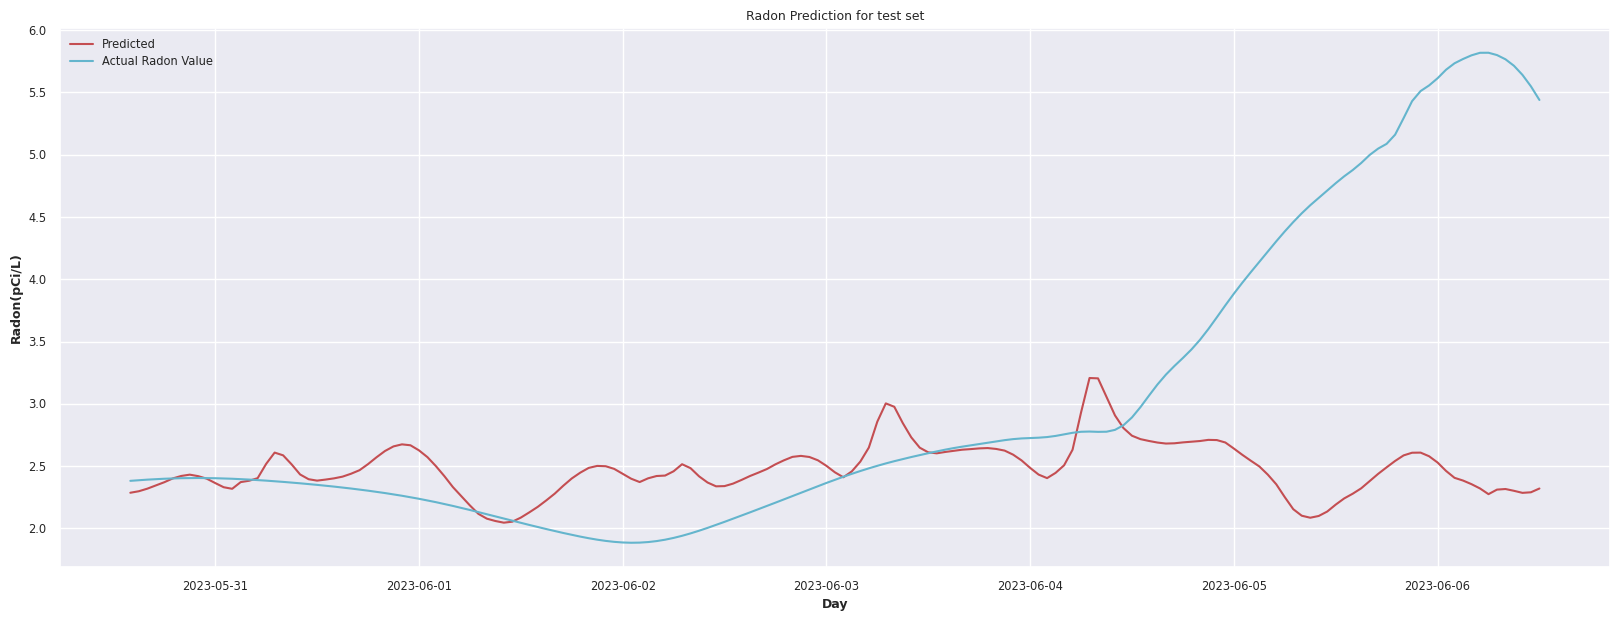

In [79]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()